# Computational Intelligence
# Lab: Evolutionary Strategy (ES)

## Outline
- Class diagram
- `ParameterSet` class
- `Function` class
- `Individual` class
- `Population` class
- `Evaluator` class
- `ES` class

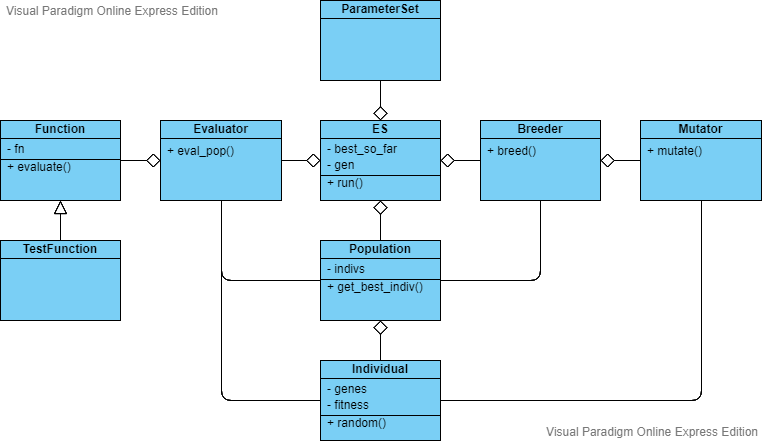

### The `ParameterSet` class
- Store important parameters of an ES run

In [1]:
class ParameterSet:
    def __init__(self):         # Assign default parameters (can be changed after an object is created)
        # Problem-related parameters
        self.is_maximize = True # Maximization problem or minimization problem
        
        # ES's parameters
        self.max_gen = 20      # Maximum number of generations
        self.lambda_ = 10      # Size of offspring population
        self.is_plus_selection = True  # (mu+lambda)-ES or (mu,lambda)-ES
        
    def print(self):
        print("--------------------------")
        print("Parameter Setting:")
        if self.is_maximize == True:
            print("Problem: Maximization")
        else:
            print("Problem: Minimization")
        print("Maximum number of generations:", self.max_gen)
        print("Size of offspring population (lambda):", self.lambda_)
        if self.is_plus_selection == True:
            print("Selection method: Plus-selection ((mu+lambda)-ES)")
        else:
            print("Selection method: Comma-selection ((mu,lambda)-ES)")
        print("--------------------------")

## The `Function` class
- Same as that in 'Lab - Genetic Algorithm (GA)'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# ----------------------------
# Base class: Function
# ----------------------------
class Function:
    def __init__(self):
        self.fn = "20 * np.sin(x[0]) + 10 * np.cos(x[1]) - 0.5 * x[0] * x[1]"   # Function (represetned as a string)
        self.domain = [[-3.0, 3.0], [3.0, 5.0]]
    
    def evaluate(self, x):
        return eval(self.fn)            # Convert string into expression and evaluate
    
    def get_num_var(self):
        return len(self.domain)
    
    def print(self):
        print("--------------------------")
        print("Function:", self.fn)
        print("Number of variables:", self.get_num_var())
        print("Domain:", self.domain)
        print("--------------------------")
    
    def plot(self, fig, is_maximize):
        if self.get_num_var() == 1:
            self.plot1D(fig, is_maximize)
        elif self.get_num_var() == 2:
            self.plot2D(fig, is_maximize)
        else:
            print("Error: Do not support plotting a function with three or more variables.")
    
    def plot1D(self, fig, is_maximize):
        # Evaluate the function $y = f(x)$
        step = 0.01
        x = np.arange(self.domain[0][0], self.domain[0][1], step)
        y = self.evaluate(x)

        # Plot the function
        plt.plot(x, y)
        plt.grid(True)
        plt.xlabel("x")
        plt.ylabel("y = f(x)")
        plt.title(str(self))
        
        # Add text 
        if is_maximize is True:
            op_idx = np.argmax(y)
            text = "max ≈ "
        else:
            op_idx = np.argmin(y) 
            text = "min ≈ "           
        plt.text(x[op_idx], y[op_idx], text + format(y[op_idx], ".4f"))  # Add text at min/max position
        plt.scatter(x[op_idx], y[op_idx], color='red')
        
        # Show figure
        fig.show()
    
    def plot2D(self, fig, is_maximize):
        # Evaluate the function $f(x0,x1)$
        step = 0.01
        x0 = np.arange(self.domain[0][0], self.domain[0][1], step)
        x1 = np.arange(self.domain[1][0], self.domain[1][1], step)
        x0, x1 = np.meshgrid(x0, x1)   
        y = self.evaluate([x0, x1])

        # Plot the function using 'plt.plot_surface'
        ax = Axes3D(fig)
        surf = ax.plot_surface(x0, x1, y, cmap = cm.viridis, antialiased = True)
        ax.set_xlabel("x[0]")
        ax.set_ylabel("x[1]")
        ax.set_title(str(self))
        
        # Add a color bar
        fig.colorbar(surf, shrink = 0.5, aspect = 5)
        
        # Add text 
        if is_maximize is True:
            op_idx = np.argmax(y)
            text = "max ≈ "
        else:
            op_idx = np.argmin(y) 
            text = "min ≈ "     
        row = op_idx // len(x0[0])  # Find the location of min/max
        col = op_idx %  len(x0[0])  # Find the location of min/max
        ax.text(x0[0][col], x1[row][0], y[row][col], text + format(y[row][col], ".4f"))  # Add text at min/max position

        # Show figure
        fig.show()
   
    def __str__(self):
        return self.fn.replace("np.", "") # To remove "np."

# ----------------------------
# Derived class: TestFunction1D
# ----------------------------
class TestFunction1D(Function):
    def __init__(self):
        self.fn = "np.sin(20 * np.pi * x) + np.cos(6 * np.pi * x)"
        self.domain = [[-.5, .5]]

# ----------------------------
# Derived class: SphereFunction
# ----------------------------
class SphereFunction(Function):
    def __init__(self):
        self.fn = "x[0] * x[0] + x[1] * x[1]"
        self.domain = [[-5.0, 5.0], [-5.0, 5.0]]
    
# ----------------------------
# Derived class: AckleyFunction
# ----------------------------
class AckleyFunction(Function):
    def __init__(self):
        self.fn = "-20 * np.exp(-0.2 * np.sqrt(0.5 * (x[0] * x[0] + x[1] * x[1])))" + \
                  "- np.exp(0.5 * (np.cos(2 * np.pi * x[0]) + np.cos(2 * np.pi * x[1]))) + np.e + 20"
        self.domain = [[-5.0, 5.0], [-5.0, 5.0]]       

C:\Users\Ukrit\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


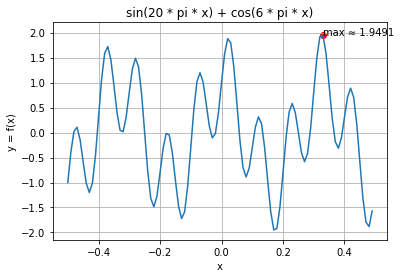

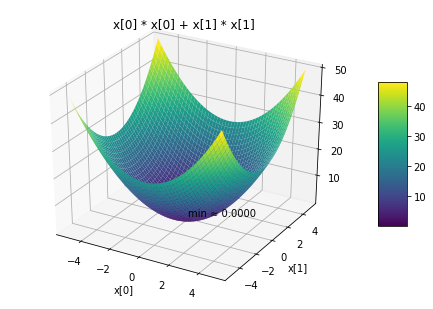

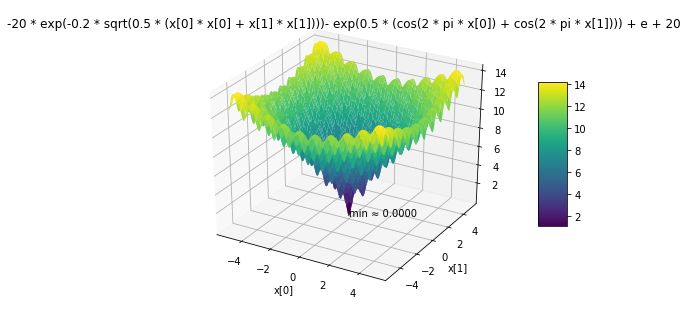

In [3]:
fn = TestFunction1D()
fn.plot(plt.figure(1), is_maximize=True)

fn = SphereFunction()
fn.plot(plt.figure(2), is_maximize=False)

fn = AckleyFunction()
fn.plot(plt.figure(3), is_maximize=False)

## The `Individual` class 
- Use real-valued representation, i.e., a sequence of real numbers $\mathbf{x}$
- Also encode the strategy parameters $\mathbf{\sigma}$
- Constructor: Number of variables as input
- Randomize genes
- Provide `is_better_than()` method to compare two individuals
- To string conversion

In [4]:
#----------------------------
DEFAULT_FITNESS = 0.0
#----------------------------
class Individual:
    def __init__(self, domains): 
        self.fitness = DEFAULT_FITNESS
        self.domains = domains
        self.genes = np.zeros(self.get_length())
        self.random()

    def get_length(self):
        return len(self.domains)
        
    def random(self):
        for i in range(self.get_length()):
            self.genes[i] = np.random.uniform(self.domains[i][0], self.domains[i][1])
    
    def is_better_than(self, other):
        return self.fitness > other.fitness # Suppose "the larger fitness, the better individual" is true.
        
    def __str__(self):
        return "gene = [ " + "".join(str(format(i, ".4f")) + " " for i in self.genes) + "], " + \
               "fit = " + str(format(self.fitness, ".4f"))

In [5]:
domains = [[-.5, .5], [0, 1], [0, 1], [0, 1]]
indiv1 = Individual(domains)
indiv1.random()
print(indiv1)

gene = [ 0.1930 0.2353 0.2053 0.6065 ], fit = 0.0000


## The `Population` class

In [6]:
class Population:
    def __init__(self, size, domains):
        self.indivs = [Individual(domains) for i in range(size)]

    def get_pop_size(self):
        return len(self.indivs)

    def get_best_indiv(self):
        best = self.indivs[0]
        for i in self.indivs:
            if i.is_better_than(best):
                best = i
        return best
    
    def get_fitness_stat(self):
        fit_list = self.get_pop_size() * [0]
        for idx in range(self.get_pop_size()):
            fit_list[idx] = self.indivs[idx].fitness
        return np.mean(fit_list), np.std(fit_list)
    
    def print(self):
        for p in self.indivs:
            print(p)

In [7]:
# Test Population class
pop = Population(5, domains)
pop.indivs[0].fitness = 15
pop.indivs[1].fitness = 24
pop.indivs[2].fitness = -10
pop.indivs[3].fitness = 2
pop.indivs[4].fitness = 18
pop.print()
print()
best = pop.get_best_indiv()
print("Best individual:", best)
avg, sd = pop.get_fitness_stat()
print("Average fitness = ", str(format(avg, ".2f")), u"\u00B1", str(format(sd, ".2f")))

pop.indivs.sort(key=lambda i: i.fitness, reverse=True)
pop.print()

gene = [ 0.1541 0.8917 0.9592 0.7866 ], fit = 15.0000
gene = [ -0.3244 0.1713 0.5262 0.9041 ], fit = 24.0000
gene = [ 0.1387 0.2737 0.0605 0.0429 ], fit = -10.0000
gene = [ -0.3958 0.9528 0.5997 0.7167 ], fit = 2.0000
gene = [ -0.1890 0.6224 0.0237 0.1328 ], fit = 18.0000

Best individual: gene = [ -0.3244 0.1713 0.5262 0.9041 ], fit = 24.0000
Average fitness =  9.80 ± 12.24
gene = [ -0.3244 0.1713 0.5262 0.9041 ], fit = 24.0000
gene = [ -0.1890 0.6224 0.0237 0.1328 ], fit = 18.0000
gene = [ 0.1541 0.8917 0.9592 0.7866 ], fit = 15.0000
gene = [ -0.3958 0.9528 0.5997 0.7167 ], fit = 2.0000
gene = [ 0.1387 0.2737 0.0605 0.0429 ], fit = -10.0000


## The `Evaluator` class

In [8]:
class Evaluator:
    def __init__(self, function, is_maximize):
        self.function = function
        self.is_maximize = is_maximize
 
    def eval_pop(self, pop, fig=plt.figure(1)):
        # Plot function
        fig.clf() # Clear figure
        self.function.plot(fig, self.is_maximize)
        
        # Evaluate each individual
        for i in pop.indivs:
            x, f = self.eval_indiv(i)
            # Plot each individual              
            if self.function.get_num_var() == 1: 
                ax = fig.gca()
                ax.plot(x, f, 'r+')            
            elif self.function.get_num_var() == 2:
                ax = fig.gca(projection = '3d')
                ax.plot([x[0]], [x[1]], f, 'r+')
            else:
                print("Error: Do not support plotting a function with three or more variables.")
            
    def eval_indiv(self, indiv):
        # Decode & evaluate
        x = indiv.genes
        f = self.function.evaluate(x)
        indiv.fitness = float(f)
        if self.is_maximize is False:
            indiv.fitness = -indiv.fitness # Reverse the sign of fitness for a minimization problem
        return x, f

<Figure size 432x288 with 0 Axes>

C:\Users\Ukrit\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


gene = [ 4.0485 1.9988 ], fit = 9.5007
gene = [ 0.1222 4.0680 ], fit = 9.2117
gene = [ 1.1473 -4.1363 ], fit = 9.9450
gene = [ 4.1801 2.6241 ], fit = 11.8998
gene = [ 3.4638 -0.0004 ], fit = 9.4509

Best individual: gene = [ 4.1801 2.6241 ], fit = 11.8998
Average fitness =  10.00 ± 0.98


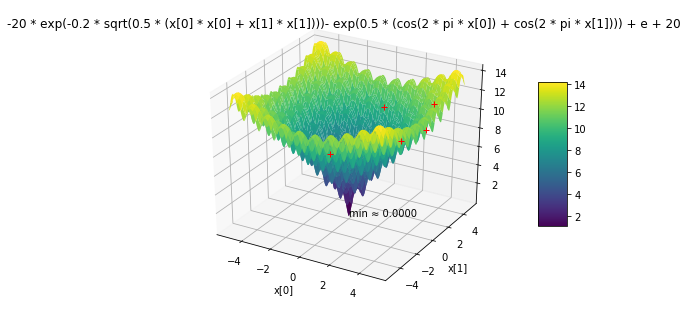

In [9]:
fn = AckleyFunction()
params = ParameterSet()
params.pop_size = 5
params.is_maximize = False
pop = Population(5, fn.domain)
evl = Evaluator(fn, params)
fig = plt.figure(1)
evl.eval_pop(pop, fig)
fig.show()

pop.print()
print()
best = pop.get_best_indiv()
print("Best individual:", best)
avg, sd = pop.get_fitness_stat()
print("Average fitness = ", str(format(avg, ".2f")), u"\u00B1", str(format(sd, ".2f")))

## The `Mutator` class

In [10]:
class Mutator:
    def __init__(self):
        pass
        
    def mutate(self, p, strategy_param):
        rand_values = np.random.randn(p.get_length()) * strategy_param # Random values
        p.genes += rand_values
        domains = np.asarray(p.domains)
        lbs, ubs = domains[:, 0], domains[:, 1]
        p.genes = np.clip(p.genes, lbs, ubs)  # Make sure mutated values are in the domain

## The `Breeder` class

In [11]:
class Breeder:
    def __init__(self):
        self.mutator = Mutator()

    def breed(self, parent, offspring_pop, strategy_param):
        for off in offspring_pop.indivs:
            # Produce and evaluate offspring
            off.genes = deepcopy(parent.genes)
            self.mutator.mutate(off, strategy_param)

## The `ES` class

In [12]:
import time
from copy import deepcopy
# -------------------------------
ROCHENBERG_TH = 1 / 5
INITIAL_STRATEGY_PARAM = 0.1
# -------------------------------
class ES:
    def __init__(self, fn, params=ParameterSet()):
        self.evaluator = Evaluator(fn, params.is_maximize)
        self.params = params   
        self.domains = fn.domain
        self.breeder = Breeder()
       
    def _reset(self):
        self.gen = 0
        self.parent = Individual(self.domains)
        self.off_pop = Population(self.params.lambda_, self.domains)
        self.strategy_param = INITIAL_STRATEGY_PARAM
     
    def update_strategy_param(self):
        num_success = 0
        print("Strategy parameter:", self.strategy_param)
        for off in self.off_pop.indivs:
            # Check if offspring is better?
            if off.is_better_than(self.parent):
                num_success += 1
                
        # Update the strategy parameter (sigma)
        self.success_ratio = num_success / self.off_pop.get_pop_size()
        if self.success_ratio >= ROCHENBERG_TH:
            self.strategy_param *= 2.0
        else:
            self.strategy_param *= 0.5
            
    def update_parent(self):
        # Initialize the current best
        if self.params.is_plus_selection == True:
            best = deepcopy(self.parent)
        else:
            best = deepcopy(self.off_pop.indivs[0])
            
        # Iteratively compare and update the current best
        for off in self.off_pop.indivs:
            if off.is_better_than(best):
                best = off       
        self.parent = deepcopy(best)
    
    def update_best_so_far(self):
        if self.parent.is_better_than(self.best_so_far):
            self.best_so_far = deepcopy(self.parent)
            
    def run(self):
        # Reset state
        self._reset()
        
        # Statistics
        gen_list = list()
        bsf_list = list()
        prt_fit_list = list()
        sigma_list = list()
        ratio_list = list()
        
        # Evaluate the initial solution
        self.evaluator.eval_indiv(self.parent)
        self.best_so_far = self.parent
        
        # Loop
        for self.gen in range(self.params.max_gen):
            print("--------------------------")
            print("Generation:", self.gen)
            print("Parent:")
            print(self.parent)

            # Breed offspring population and evaluate
            self.breeder.breed(self.parent, self.off_pop, self.strategy_param) 
            #self.evaluator.eval_pop(self.off_pop)
            for off in self.off_pop.indivs:
                self.evaluator.eval_indiv(off)
            print("Offspring:")
            self.off_pop.print()
            
            # Update strategy parameter
            self.update_strategy_param()
            
            # Plot graphs
            self.plot_solutions(plt.figure(1))
            self.plot_stats(plt.figure(2), gen_list, bsf_list, prt_fit_list, sigma_list, ratio_list)
            
            # Update best-so-far
            self.update_parent()
            self.update_best_so_far()
            print("Best-so-far:", self.best_so_far)

            # Delay
            time.sleep(0.5)
            
        return self.best_so_far
    
    def plot_solutions(self, fig):
        # Plot function
        self.evaluator.function.plot(fig, self.params.is_maximize)
        
        # Plot offspring solutions
        for off in self.off_pop.indivs:
            x = off.genes
            y = self.evaluator.function.evaluate(x)
            if len(self.domains) == 1:
                plt.scatter(x, y, color='blue')
            elif len(self.domains) == 2:
                plt.plot([x[0]], [x[1]], y, 'b+')
        
        # Plot parent solution
        x = self.parent.genes
        y = self.evaluator.function.evaluate(x)
        if len(self.domains) == 1:
            plt.scatter(x, y, color='green')
        elif len(self.domains) == 2:
            plt.plot([x[0]], [x[1]], y, 'r+')
            
        plt.show()
        
    def plot_stats(self, fig, gen_list, bsf_list, prt_fit_list, sigma_list, ratio_list):
        # Update list
        gen_list.append(self.gen)
        bsf_list.append(self.best_so_far.fitness)
        prt_fit_list.append(self.parent.fitness)
        sigma_list.append(self.strategy_param)
        ratio_list.append(self.success_ratio)

        # Clear figure and re-plot
        plt.figure(2)                               # Choose a figure
        plt.clf()                                   # Clear figure
        plt.plot(gen_list, bsf_list, label = 'Best-so-far')
        plt.plot(gen_list, prt_fit_list, label = 'Parent\'s fitness')
        plt.plot(gen_list, sigma_list, label = 'Strategy parameter')
        plt.plot(gen_list, ratio_list, label = 'Successful mutations')
        #plt.errorbar(gen_list, avg_list, sd_list, label = 'Avg & SD')

        # Graph settings
        ax = plt.gca()                              # Get current axis
        ax.set_xlim(xmin = -0.5, xmax = self.params.max_gen)
        #ax.set_xticks(gen_list, minor = True)      # Set x-ticks according to generations
        ax.set_xticks(gen_list)                     # Set x-ticks according to generations
        yticks = list(ax.get_yticks())          
        yticks.append(self.best_so_far.fitness)     # Add best-so-far to (auto) y-ticks
        ax.set_yticks( yticks )                     # Aet y-ticks      
        ax.grid()                                   # Show grid
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title("Simple ES")
        ax.set_ylabel('Fitness')
        ax.set_xlabel('Generation')

        # Show and pause
        plt.show(block = False)
        plt.pause(0.01)   

## Test the `ES` class: Function with one variable

In [13]:
# Create a function object
fn = TestFunction1D()
# Verify function
fn.print()

# Create a set of parameters
params = ParameterSet()
# Adjust some parameters
params.is_maximize = True
params.max_gen = 30
params.lambda_ = 10
params.is_plus_selection = False
# Verify parameters
params.print()

--------------------------
Function: np.sin(20 * np.pi * x) + np.cos(6 * np.pi * x)
Number of variables: 1
Domain: [[-0.5, 0.5]]
--------------------------
--------------------------
Parameter Setting:
Problem: Maximization
Maximum number of generations: 30
Size of offspring population (lambda): 10
Selection method: Plus-selection ((mu,lambda)-ES)
--------------------------


--------------------------
Generation: 0
Parent:
gene = [ -0.4919 ], fit = -0.5006
Offspring:
gene = [ -0.3392 ], fit = 0.3673
gene = [ -0.4735 ], fit = 0.1177
gene = [ -0.2889 ], fit = 1.3105
gene = [ -0.5000 ], fit = -1.0000
gene = [ -0.5000 ], fit = -1.0000
gene = [ -0.4283 ], fit = -1.1961
gene = [ -0.4883 ], fit = -0.3063
gene = [ -0.5000 ], fit = -1.0000
gene = [ -0.4937 ], fit = -0.6087
gene = [ -0.5000 ], fit = -1.0000
Strategy parameter: 0.1


C:\Users\Ukrit\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


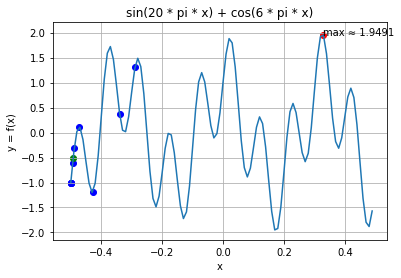

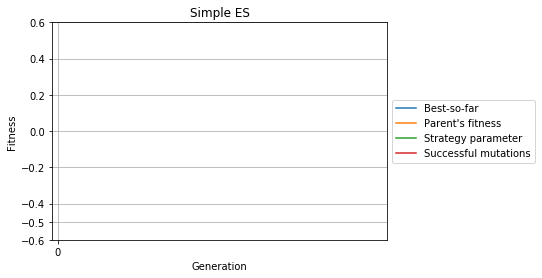

Best-so-far: gene = [ -0.2889 ], fit = 1.3105
--------------------------
Generation: 1
Parent:
gene = [ -0.2889 ], fit = 1.3105
Offspring:
gene = [ -0.4280 ], fit = -1.1942
gene = [ 0.0684 ], fit = -0.6369
gene = [ -0.1310 ], fit = -1.7117
gene = [ -0.2040 ], fit = -1.0103
gene = [ -0.2214 ], fit = -1.4879
gene = [ -0.4984 ], fit = -0.9023
gene = [ -0.4987 ], fit = -0.9205
gene = [ -0.3095 ], fit = 0.3378
gene = [ -0.2375 ], fit = -0.9434
gene = [ -0.2827 ], fit = 1.4627
Strategy parameter: 0.2


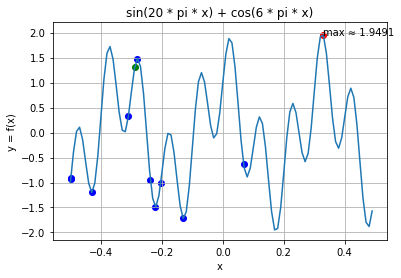

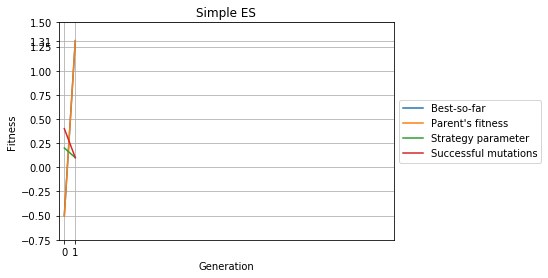

Best-so-far: gene = [ -0.2827 ], fit = 1.4627
--------------------------
Generation: 2
Parent:
gene = [ -0.2827 ], fit = 1.4627
Offspring:
gene = [ -0.2349 ], fit = -1.0916
gene = [ -0.1507 ], fit = -0.9125
gene = [ -0.2829 ], fit = 1.4604
gene = [ -0.3233 ], fit = -0.0121
gene = [ -0.1505 ], fit = -0.9241
gene = [ -0.1798 ], fit = -0.0146
gene = [ -0.2657 ], fit = 1.1256
gene = [ -0.2521 ], fit = 0.1689
gene = [ -0.2730 ], fit = 1.4114
gene = [ -0.3496 ], fit = 0.9278
Strategy parameter: 0.1


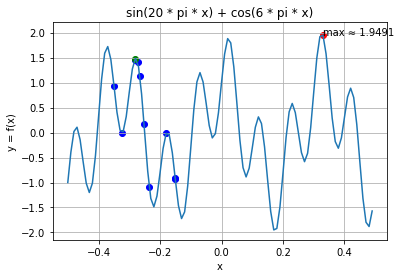

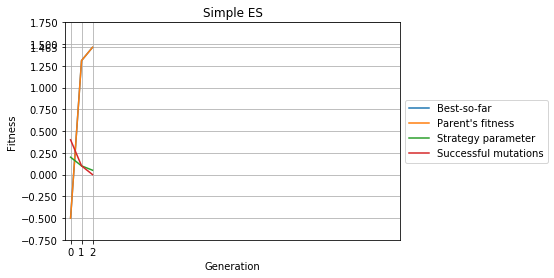

Best-so-far: gene = [ -0.2827 ], fit = 1.4627
--------------------------
Generation: 3
Parent:
gene = [ -0.2829 ], fit = 1.4604
Offspring:
gene = [ -0.3383 ], fit = 0.3246
gene = [ -0.3319 ], fit = 0.0929
gene = [ -0.2254 ], fit = -1.4466
gene = [ -0.2829 ], fit = 1.4610
gene = [ -0.2677 ], fit = 1.2236
gene = [ -0.3908 ], fit = 1.0115
gene = [ -0.2294 ], fit = -1.3407
gene = [ -0.3221 ], fit = -0.0060
gene = [ -0.3408 ], fit = 0.4459
gene = [ -0.2876 ], fit = 1.3524
Strategy parameter: 0.05


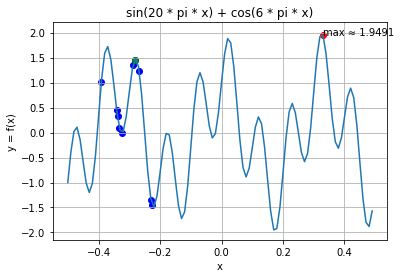

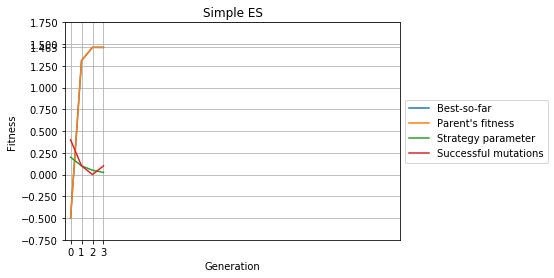

Best-so-far: gene = [ -0.2827 ], fit = 1.4627
--------------------------
Generation: 4
Parent:
gene = [ -0.2829 ], fit = 1.4610
Offspring:
gene = [ -0.2782 ], fit = 1.4867
gene = [ -0.2267 ], fit = -1.4191
gene = [ -0.2884 ], fit = 1.3298
gene = [ -0.2582 ], fit = 0.6494
gene = [ -0.3065 ], fit = 0.4791
gene = [ -0.2327 ], fit = -1.2068
gene = [ -0.2512 ], fit = 0.0954
gene = [ -0.2958 ], fit = 1.0186
gene = [ -0.2762 ], fit = 1.4717
gene = [ -0.2986 ], fit = 0.8792
Strategy parameter: 0.025


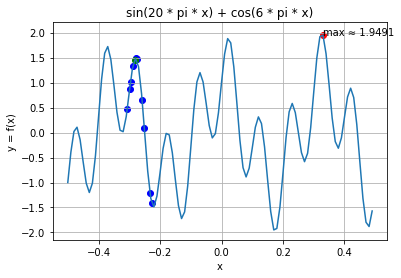

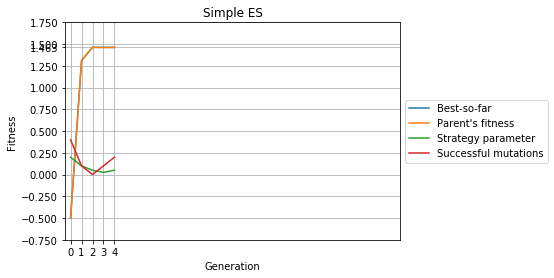

Best-so-far: gene = [ -0.2782 ], fit = 1.4867
--------------------------
Generation: 5
Parent:
gene = [ -0.2782 ], fit = 1.4867
Offspring:
gene = [ -0.3181 ], fit = 0.0507
gene = [ -0.3189 ], fit = 0.0349
gene = [ -0.2306 ], fit = -1.2971
gene = [ -0.2376 ], fit = -0.9323
gene = [ -0.2622 ], fit = 0.9209
gene = [ -0.2275 ], fit = -1.4000
gene = [ -0.3061 ], fit = 0.4977
gene = [ -0.2583 ], fit = 0.6534
gene = [ -0.2832 ], fit = 1.4564
gene = [ -0.2469 ], fit = -0.2480
Strategy parameter: 0.05


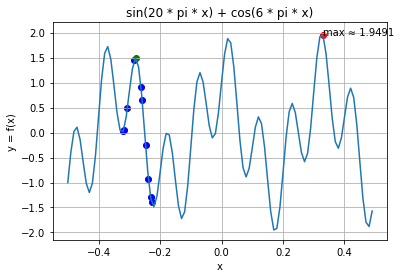

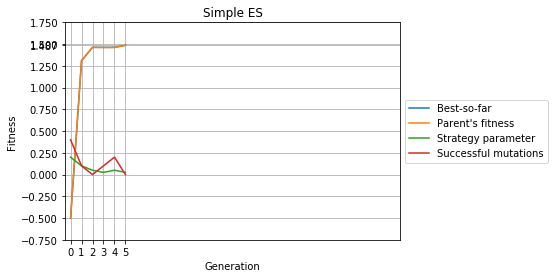

Best-so-far: gene = [ -0.2782 ], fit = 1.4867
--------------------------
Generation: 6
Parent:
gene = [ -0.2832 ], fit = 1.4564
Offspring:
gene = [ -0.3001 ], fit = 0.8049
gene = [ -0.2809 ], fit = 1.4820
gene = [ -0.2948 ], fit = 1.0681
gene = [ -0.2899 ], fit = 1.2749
gene = [ -0.3184 ], fit = 0.0459
gene = [ -0.3132 ], fit = 0.1918
gene = [ -0.2949 ], fit = 1.0618
gene = [ -0.2725 ], fit = 1.3998
gene = [ -0.3443 ], fit = 0.6287
gene = [ -0.2876 ], fit = 1.3524
Strategy parameter: 0.025


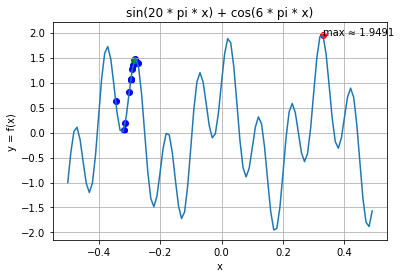

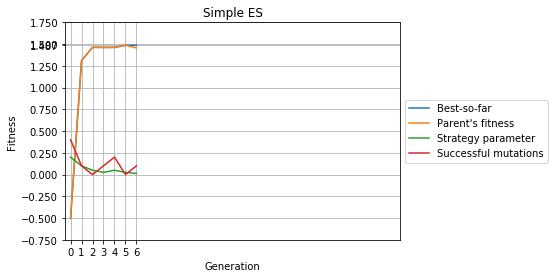

Best-so-far: gene = [ -0.2782 ], fit = 1.4867
--------------------------
Generation: 7
Parent:
gene = [ -0.2809 ], fit = 1.4820
Offspring:
gene = [ -0.2592 ], fit = 0.7199
gene = [ -0.2878 ], fit = 1.3474
gene = [ -0.2831 ], fit = 1.4576
gene = [ -0.2821 ], fit = 1.4704
gene = [ -0.2978 ], fit = 0.9235
gene = [ -0.2784 ], fit = 1.4874
gene = [ -0.2867 ], fit = 1.3798
gene = [ -0.2907 ], fit = 1.2465
gene = [ -0.2966 ], fit = 0.9796
gene = [ -0.2872 ], fit = 1.3642
Strategy parameter: 0.0125


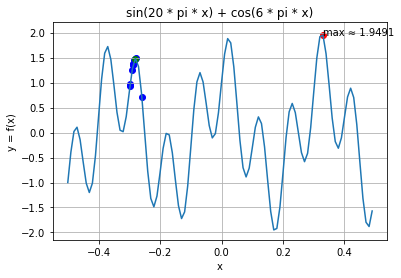

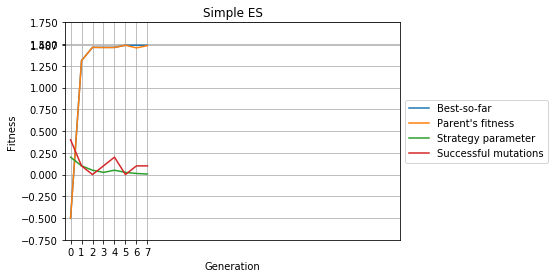

Best-so-far: gene = [ -0.2784 ], fit = 1.4874
--------------------------
Generation: 8
Parent:
gene = [ -0.2784 ], fit = 1.4874
Offspring:
gene = [ -0.2772 ], fit = 1.4809
gene = [ -0.2865 ], fit = 1.3852
gene = [ -0.2826 ], fit = 1.4643
gene = [ -0.2729 ], fit = 1.4105
gene = [ -0.2743 ], fit = 1.4407
gene = [ -0.2760 ], fit = 1.4692
gene = [ -0.2701 ], fit = 1.3214
gene = [ -0.2784 ], fit = 1.4874
gene = [ -0.2779 ], fit = 1.4853
gene = [ -0.2850 ], fit = 1.4222
Strategy parameter: 0.00625


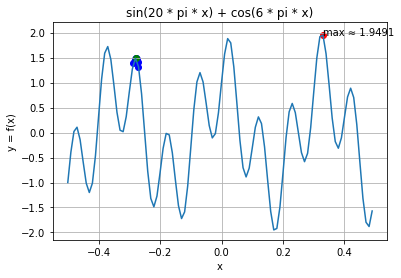

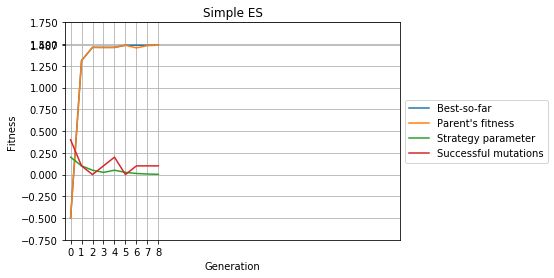

Best-so-far: gene = [ -0.2784 ], fit = 1.4874
--------------------------
Generation: 9
Parent:
gene = [ -0.2784 ], fit = 1.4874
Offspring:
gene = [ -0.2838 ], fit = 1.4455
gene = [ -0.2745 ], fit = 1.4444
gene = [ -0.2763 ], fit = 1.4722
gene = [ -0.2824 ], fit = 1.4669
gene = [ -0.2765 ], fit = 1.4741
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2768 ], fit = 1.4776
gene = [ -0.2787 ], fit = 1.4881
gene = [ -0.2787 ], fit = 1.4881
gene = [ -0.2807 ], fit = 1.4833
Strategy parameter: 0.003125


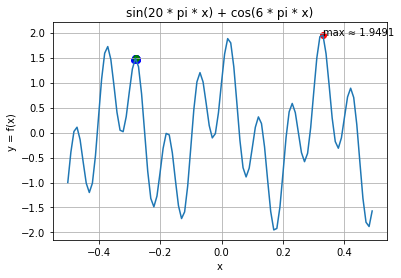

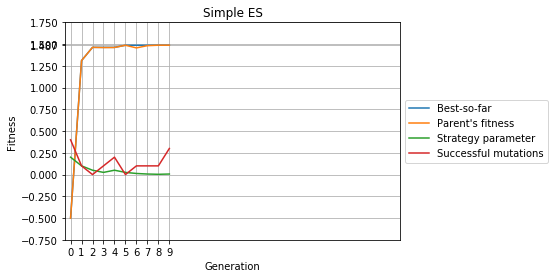

Best-so-far: gene = [ -0.2790 ], fit = 1.4884
--------------------------
Generation: 10
Parent:
gene = [ -0.2790 ], fit = 1.4884
Offspring:
gene = [ -0.2746 ], fit = 1.4462
gene = [ -0.2762 ], fit = 1.4707
gene = [ -0.2888 ], fit = 1.3164
gene = [ -0.2812 ], fit = 1.4796
gene = [ -0.2822 ], fit = 1.4692
gene = [ -0.2841 ], fit = 1.4412
gene = [ -0.2819 ], fit = 1.4730
gene = [ -0.2722 ], fit = 1.3899
gene = [ -0.2953 ], fit = 1.0458
gene = [ -0.2801 ], fit = 1.4863
Strategy parameter: 0.00625


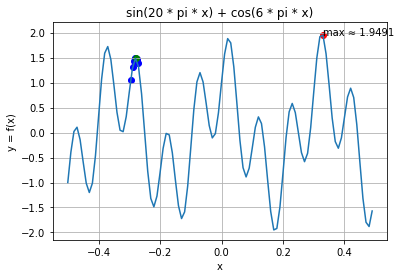

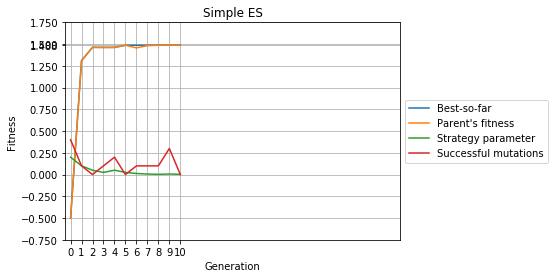

Best-so-far: gene = [ -0.2790 ], fit = 1.4884
--------------------------
Generation: 11
Parent:
gene = [ -0.2801 ], fit = 1.4863
Offspring:
gene = [ -0.2839 ], fit = 1.4432
gene = [ -0.2813 ], fit = 1.4788
gene = [ -0.2771 ], fit = 1.4798
gene = [ -0.2848 ], fit = 1.4271
gene = [ -0.2840 ], fit = 1.4426
gene = [ -0.2821 ], fit = 1.4705
gene = [ -0.2767 ], fit = 1.4769
gene = [ -0.2833 ], fit = 1.4536
gene = [ -0.2856 ], fit = 1.4075
gene = [ -0.2828 ], fit = 1.4624
Strategy parameter: 0.003125


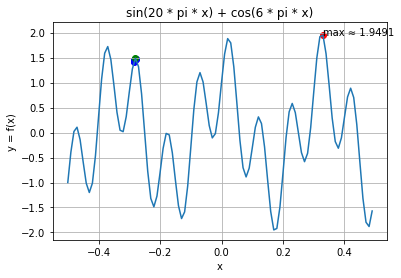

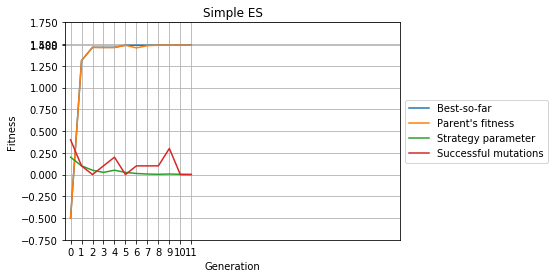

Best-so-far: gene = [ -0.2790 ], fit = 1.4884
--------------------------
Generation: 12
Parent:
gene = [ -0.2771 ], fit = 1.4798
Offspring:
gene = [ -0.2774 ], fit = 1.4826
gene = [ -0.2788 ], fit = 1.4882
gene = [ -0.2768 ], fit = 1.4779
gene = [ -0.2761 ], fit = 1.4701
gene = [ -0.2799 ], fit = 1.4874
gene = [ -0.2762 ], fit = 1.4714
gene = [ -0.2796 ], fit = 1.4879
gene = [ -0.2765 ], fit = 1.4747
gene = [ -0.2779 ], fit = 1.4854
gene = [ -0.2768 ], fit = 1.4778
Strategy parameter: 0.0015625


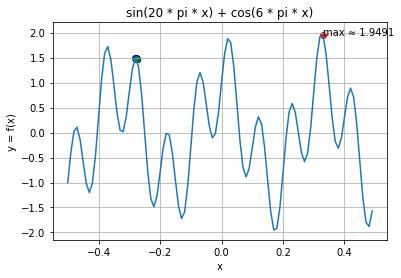

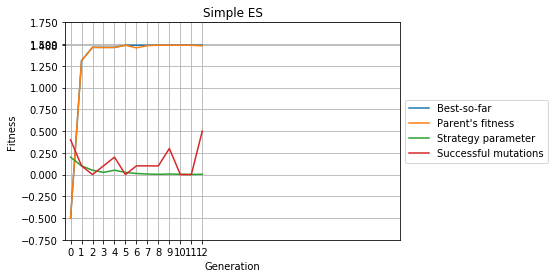

Best-so-far: gene = [ -0.2790 ], fit = 1.4884
--------------------------
Generation: 13
Parent:
gene = [ -0.2788 ], fit = 1.4882
Offspring:
gene = [ -0.2782 ], fit = 1.4868
gene = [ -0.2785 ], fit = 1.4877
gene = [ -0.2801 ], fit = 1.4866
gene = [ -0.2819 ], fit = 1.4734
gene = [ -0.2830 ], fit = 1.4585
gene = [ -0.2776 ], fit = 1.4835
gene = [ -0.2805 ], fit = 1.4844
gene = [ -0.2814 ], fit = 1.4780
gene = [ -0.2811 ], fit = 1.4810
gene = [ -0.2767 ], fit = 1.4767
Strategy parameter: 0.003125


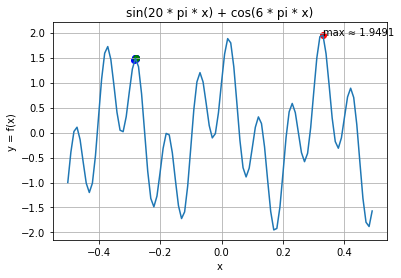

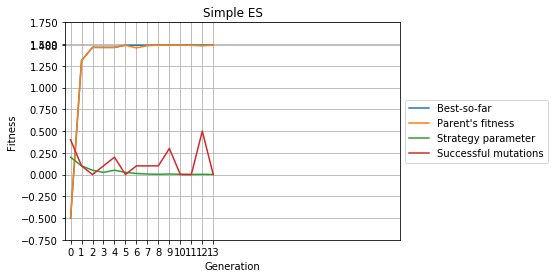

Best-so-far: gene = [ -0.2790 ], fit = 1.4884
--------------------------
Generation: 14
Parent:
gene = [ -0.2785 ], fit = 1.4877
Offspring:
gene = [ -0.2806 ], fit = 1.4842
gene = [ -0.2766 ], fit = 1.4754
gene = [ -0.2779 ], fit = 1.4854
gene = [ -0.2782 ], fit = 1.4867
gene = [ -0.2772 ], fit = 1.4811
gene = [ -0.2794 ], fit = 1.4883
gene = [ -0.2805 ], fit = 1.4844
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2806 ], fit = 1.4843
gene = [ -0.2776 ], fit = 1.4839
Strategy parameter: 0.0015625


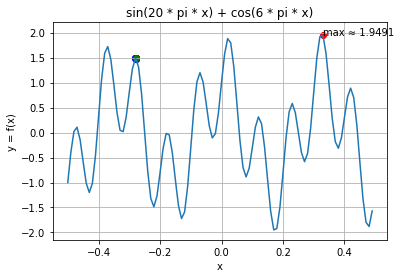

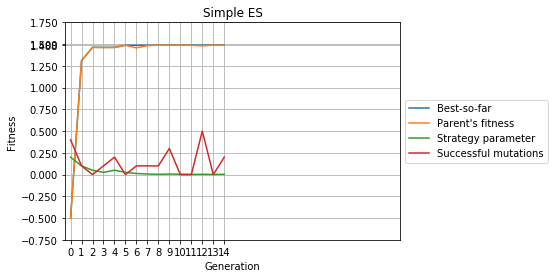

Best-so-far: gene = [ -0.2792 ], fit = 1.4884
--------------------------
Generation: 15
Parent:
gene = [ -0.2792 ], fit = 1.4884
Offspring:
gene = [ -0.2788 ], fit = 1.4882
gene = [ -0.2759 ], fit = 1.4677
gene = [ -0.2874 ], fit = 1.3607
gene = [ -0.2820 ], fit = 1.4721
gene = [ -0.2812 ], fit = 1.4798
gene = [ -0.2812 ], fit = 1.4798
gene = [ -0.2768 ], fit = 1.4778
gene = [ -0.2764 ], fit = 1.4737
gene = [ -0.2749 ], fit = 1.4528
gene = [ -0.2782 ], fit = 1.4867
Strategy parameter: 0.003125


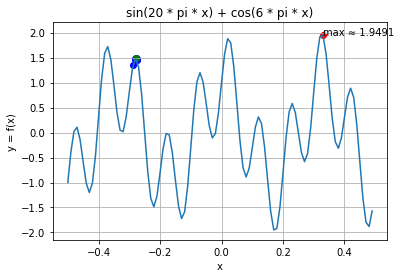

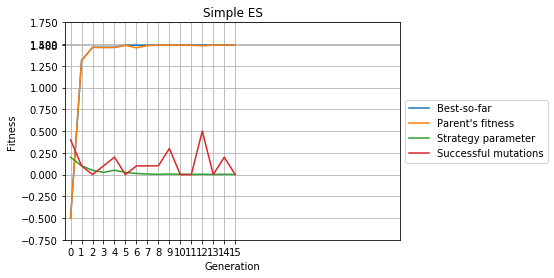

Best-so-far: gene = [ -0.2792 ], fit = 1.4884
--------------------------
Generation: 16
Parent:
gene = [ -0.2788 ], fit = 1.4882
Offspring:
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2812 ], fit = 1.4801
gene = [ -0.2787 ], fit = 1.4880
gene = [ -0.2788 ], fit = 1.4882
gene = [ -0.2798 ], fit = 1.4874
gene = [ -0.2786 ], fit = 1.4878
gene = [ -0.2800 ], fit = 1.4868
gene = [ -0.2807 ], fit = 1.4837
gene = [ -0.2778 ], fit = 1.4851
gene = [ -0.2770 ], fit = 1.4790
Strategy parameter: 0.0015625


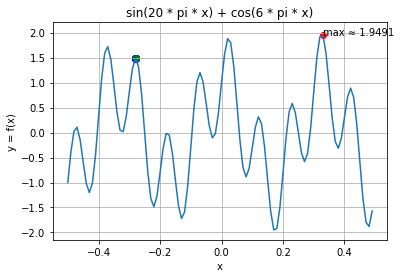

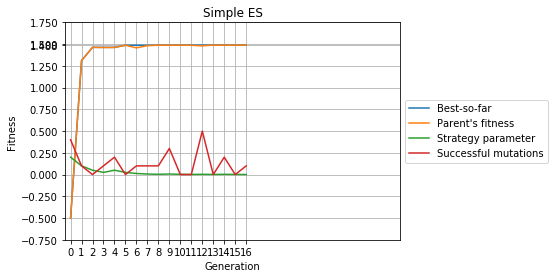

Best-so-far: gene = [ -0.2792 ], fit = 1.4884
--------------------------
Generation: 17
Parent:
gene = [ -0.2792 ], fit = 1.4884
Offspring:
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2805 ], fit = 1.4844
gene = [ -0.2787 ], fit = 1.4881
gene = [ -0.2784 ], fit = 1.4875
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2781 ], fit = 1.4862
gene = [ -0.2793 ], fit = 1.4883
gene = [ -0.2778 ], fit = 1.4850
gene = [ -0.2784 ], fit = 1.4873
Strategy parameter: 0.00078125


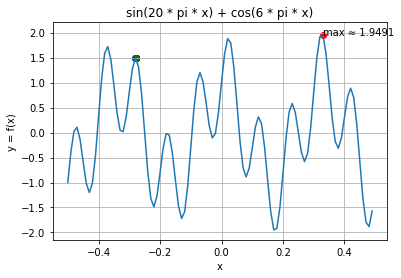

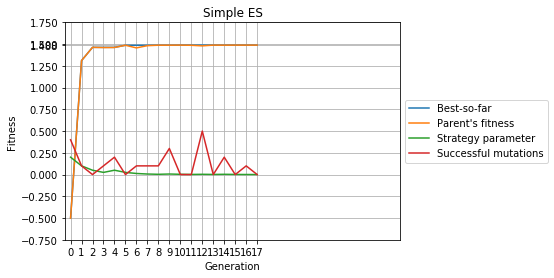

Best-so-far: gene = [ -0.2792 ], fit = 1.4884
--------------------------
Generation: 18
Parent:
gene = [ -0.2792 ], fit = 1.4884
Offspring:
gene = [ -0.2784 ], fit = 1.4875
gene = [ -0.2795 ], fit = 1.4881
gene = [ -0.2786 ], fit = 1.4880
gene = [ -0.2793 ], fit = 1.4884
gene = [ -0.2794 ], fit = 1.4883
gene = [ -0.2795 ], fit = 1.4882
gene = [ -0.2795 ], fit = 1.4881
gene = [ -0.2793 ], fit = 1.4884
gene = [ -0.2789 ], fit = 1.4883
gene = [ -0.2786 ], fit = 1.4879
Strategy parameter: 0.000390625


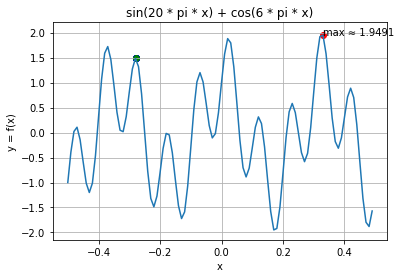

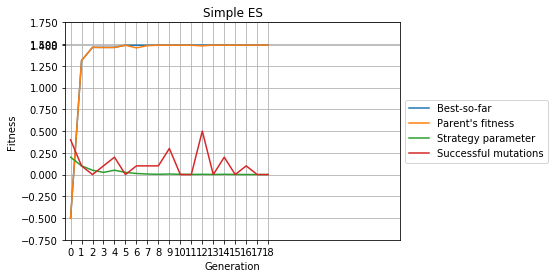

Best-so-far: gene = [ -0.2792 ], fit = 1.4884
--------------------------
Generation: 19
Parent:
gene = [ -0.2793 ], fit = 1.4884
Offspring:
gene = [ -0.2793 ], fit = 1.4884
gene = [ -0.2793 ], fit = 1.4884
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2789 ], fit = 1.4883
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2797 ], fit = 1.4878
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2795 ], fit = 1.4882
gene = [ -0.2799 ], fit = 1.4873
Strategy parameter: 0.0001953125


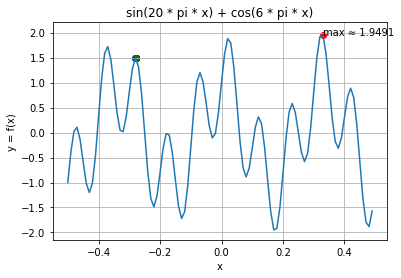

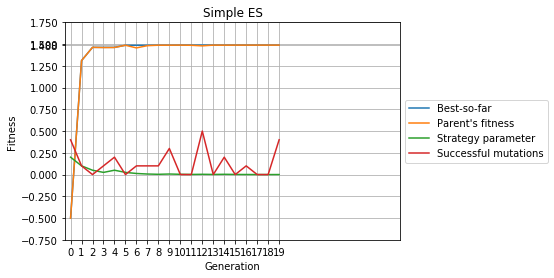

Best-so-far: gene = [ -0.2792 ], fit = 1.4884
--------------------------
Generation: 20
Parent:
gene = [ -0.2792 ], fit = 1.4884
Offspring:
gene = [ -0.2788 ], fit = 1.4882
gene = [ -0.2797 ], fit = 1.4877
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2789 ], fit = 1.4883
gene = [ -0.2797 ], fit = 1.4877
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2795 ], fit = 1.4882
gene = [ -0.2793 ], fit = 1.4883
gene = [ -0.2795 ], fit = 1.4881
Strategy parameter: 0.000390625


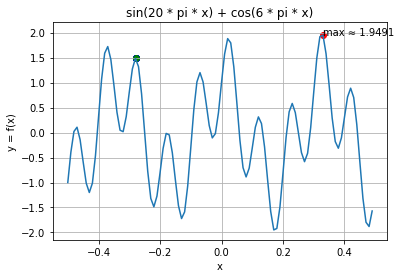

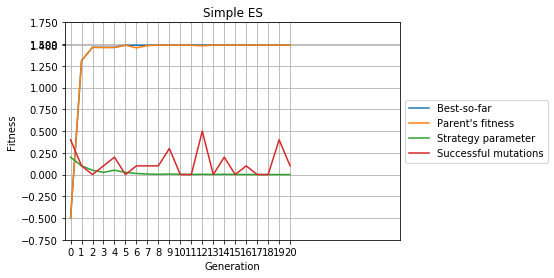

Best-so-far: gene = [ -0.2791 ], fit = 1.4884
--------------------------
Generation: 21
Parent:
gene = [ -0.2791 ], fit = 1.4884
Offspring:
gene = [ -0.2795 ], fit = 1.4882
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2789 ], fit = 1.4883
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2794 ], fit = 1.4883
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2789 ], fit = 1.4884
gene = [ -0.2792 ], fit = 1.4884
Strategy parameter: 0.0001953125


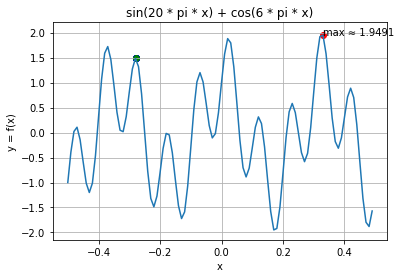

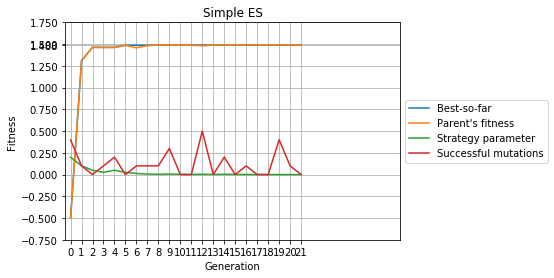

Best-so-far: gene = [ -0.2791 ], fit = 1.4884
--------------------------
Generation: 22
Parent:
gene = [ -0.2791 ], fit = 1.4884
Offspring:
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2792 ], fit = 1.4884
Strategy parameter: 9.765625e-05


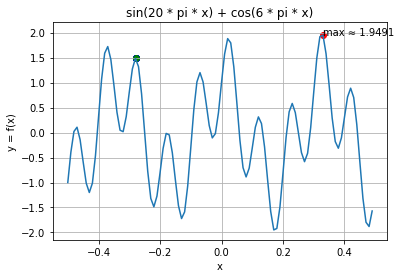

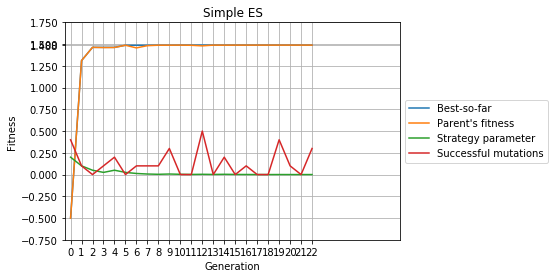

Best-so-far: gene = [ -0.2791 ], fit = 1.4884
--------------------------
Generation: 23
Parent:
gene = [ -0.2791 ], fit = 1.4884
Offspring:
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2794 ], fit = 1.4883
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2789 ], fit = 1.4884
Strategy parameter: 0.0001953125


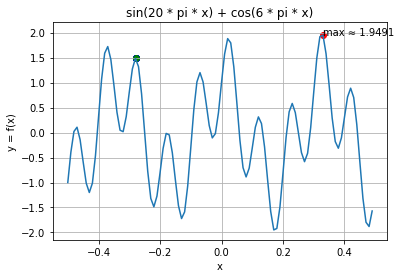

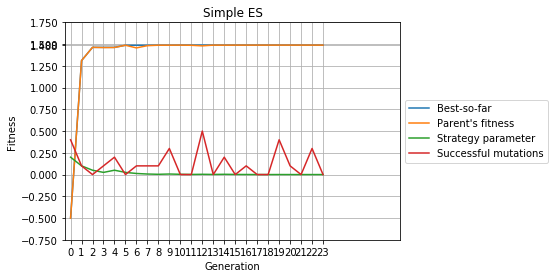

Best-so-far: gene = [ -0.2791 ], fit = 1.4884
--------------------------
Generation: 24
Parent:
gene = [ -0.2791 ], fit = 1.4884
Offspring:
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2792 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2794 ], fit = 1.4883
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2793 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
Strategy parameter: 9.765625e-05


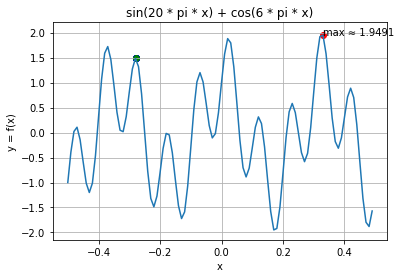

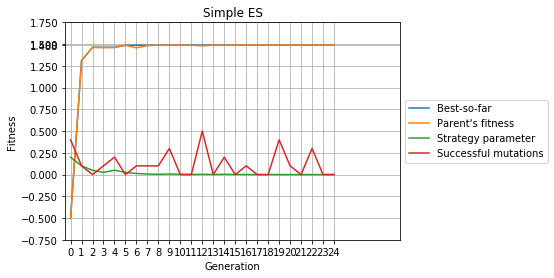

Best-so-far: gene = [ -0.2791 ], fit = 1.4884
--------------------------
Generation: 25
Parent:
gene = [ -0.2791 ], fit = 1.4884
Offspring:
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2790 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
Strategy parameter: 4.8828125e-05


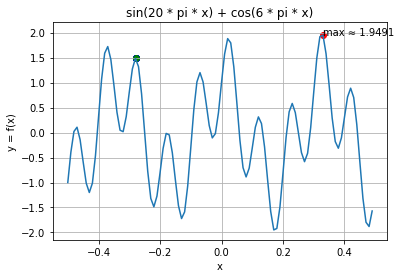

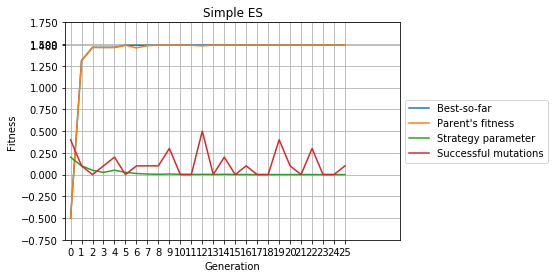

Best-so-far: gene = [ -0.2791 ], fit = 1.4884
--------------------------
Generation: 26
Parent:
gene = [ -0.2791 ], fit = 1.4884
Offspring:
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2792 ], fit = 1.4884
Strategy parameter: 2.44140625e-05


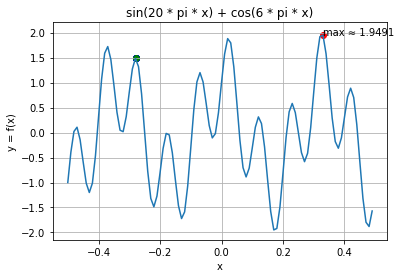

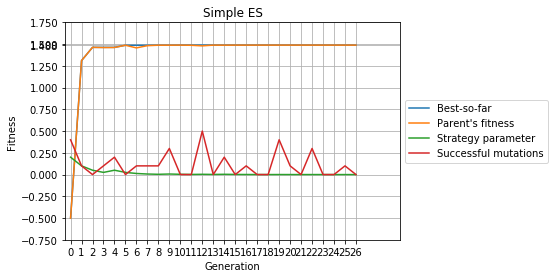

Best-so-far: gene = [ -0.2791 ], fit = 1.4884
--------------------------
Generation: 27
Parent:
gene = [ -0.2791 ], fit = 1.4884
Offspring:
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
Strategy parameter: 1.220703125e-05


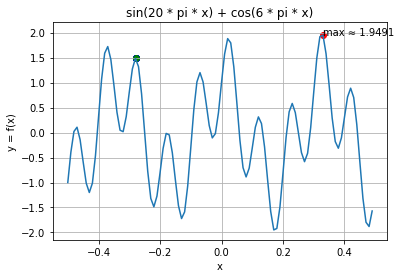

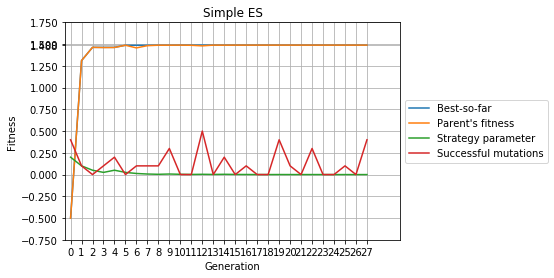

Best-so-far: gene = [ -0.2791 ], fit = 1.4884
--------------------------
Generation: 28
Parent:
gene = [ -0.2791 ], fit = 1.4884
Offspring:
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
Strategy parameter: 2.44140625e-05


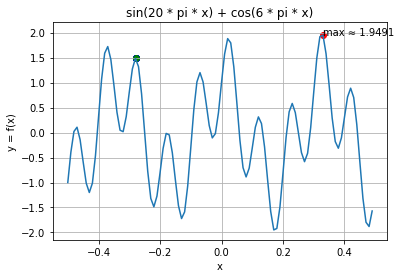

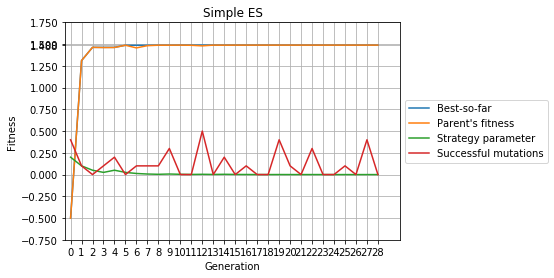

Best-so-far: gene = [ -0.2791 ], fit = 1.4884
--------------------------
Generation: 29
Parent:
gene = [ -0.2791 ], fit = 1.4884
Offspring:
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
gene = [ -0.2791 ], fit = 1.4884
Strategy parameter: 1.220703125e-05


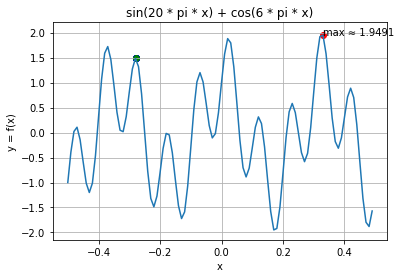

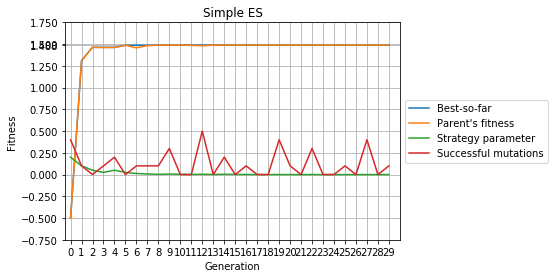

Best-so-far: gene = [ -0.2791 ], fit = 1.4884

The best individual founded: gene = [ -0.2791 ], fit = 1.4884
Solution:
x = [-0.27911953]
y = f(x) = [1.48842891]


In [14]:
es = ES(fn, params)
best_indiv = es.run()

# Display result
print("\nThe best individual founded:", best_indiv)

print("Solution:")
x = es.parent.genes
print("x =", x)
y = es.evaluator.function.evaluate(x)
print("y = f(x) =", y)

## Test the `ES` class: Function with two variables

In [15]:
# Create a function object
fn = AckleyFunction()
# Verify function
fn.print()

# Create a set of parameters
params = ParameterSet()
# Adjust some parameters
params.is_maximize = False
params.max_gen = 30
params.lambda_ = 10
params.is_plus_selection = False
# Verify parameters
params.print()

--------------------------
Function: -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[0] * x[0] + x[1] * x[1])))- np.exp(0.5 * (np.cos(2 * np.pi * x[0]) + np.cos(2 * np.pi * x[1]))) + np.e + 20
Number of variables: 2
Domain: [[-5.0, 5.0], [-5.0, 5.0]]
--------------------------
--------------------------
Parameter Setting:
Problem: Minimization
Maximum number of generations: 30
Size of offspring population (lambda): 10
Selection method: Plus-selection ((mu,lambda)-ES)
--------------------------


--------------------------
Generation: 0
Parent:
gene = [ -3.0987 -1.7331 ], fit = -9.1885
Offspring:
gene = [ -3.3385 -1.9910 ], fit = -9.9106
gene = [ -3.0594 -1.7262 ], fit = -9.0701
gene = [ -2.9399 -1.7356 ], fit = -8.8559
gene = [ -3.1591 -1.8471 ], fit = -9.0533
gene = [ -2.9174 -1.6471 ], fit = -9.1234
gene = [ -3.0446 -1.8830 ], fit = -8.3206
gene = [ -3.1615 -1.7531 ], fit = -9.4086
gene = [ -3.0436 -1.8065 ], fit = -8.6690
gene = [ -3.1047 -1.7895 ], fit = -8.9905
gene = [ -2.9892 -1.7617 ], fit = -8.7658
Strategy parameter: 0.1


C:\Users\Ukrit\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


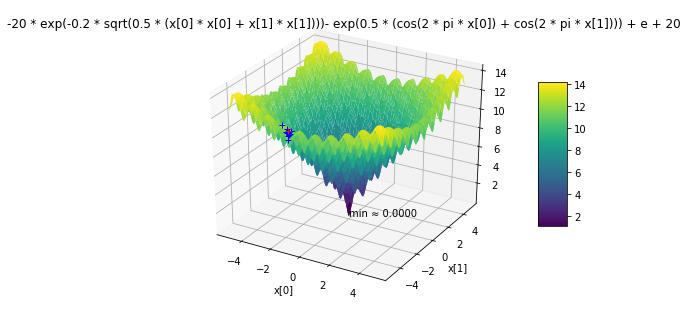

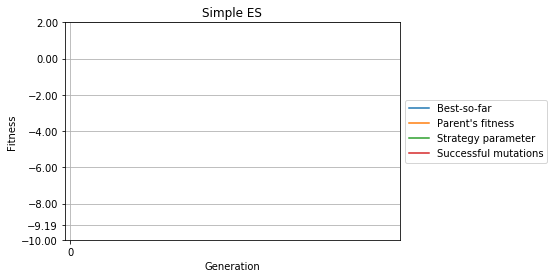

Best-so-far: gene = [ -3.0446 -1.8830 ], fit = -8.3206
--------------------------
Generation: 1
Parent:
gene = [ -3.0446 -1.8830 ], fit = -8.3206
Offspring:
gene = [ -2.9580 -1.8900 ], fit = -8.1621
gene = [ -2.9707 -2.2026 ], fit = -8.9700
gene = [ -2.9306 -1.9500 ], fit = -8.0298
gene = [ -3.0144 -1.8748 ], fit = -8.2702
gene = [ -2.6710 -1.4185 ], fit = -9.1685
gene = [ -3.0393 -1.7911 ], fit = -8.7294
gene = [ -2.9388 -1.6276 ], fit = -9.1590
gene = [ -3.0304 -1.9275 ], fit = -8.1235
gene = [ -3.3218 -1.9921 ], fit = -9.8283
gene = [ -3.3105 -2.0299 ], fit = -9.8125
Strategy parameter: 0.2


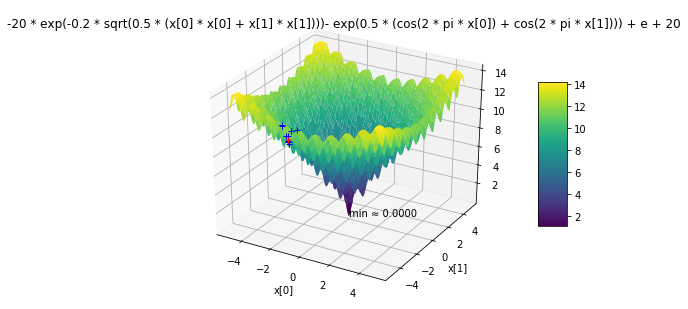

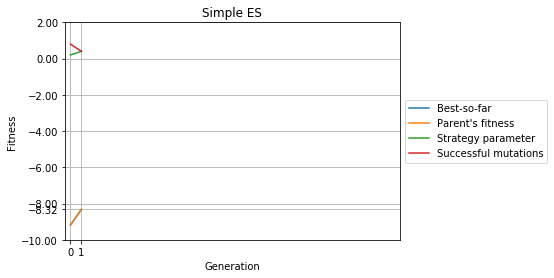

Best-so-far: gene = [ -2.9306 -1.9500 ], fit = -8.0298
--------------------------
Generation: 2
Parent:
gene = [ -2.9306 -1.9500 ], fit = -8.0298
Offspring:
gene = [ -2.6027 -2.1710 ], fit = -9.4830
gene = [ -3.3001 -2.0457 ], fit = -9.7852
gene = [ -3.3446 -1.6530 ], fit = -10.3505
gene = [ -3.1995 -1.7939 ], fit = -9.4733
gene = [ -3.5051 -1.7431 ], fit = -10.6272
gene = [ -3.7383 -1.9984 ], fit = -10.1470
gene = [ -2.9661 -1.4535 ], fit = -9.1723
gene = [ -2.5982 -2.3006 ], fit = -9.9064
gene = [ -2.3067 -3.0468 ], fit = -9.7129
gene = [ -2.4248 -2.1441 ], fit = -9.1916
Strategy parameter: 0.4


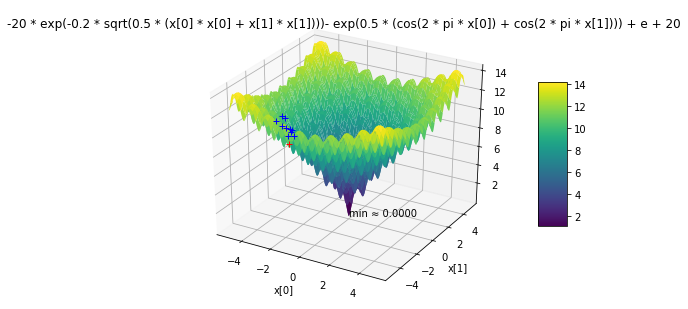

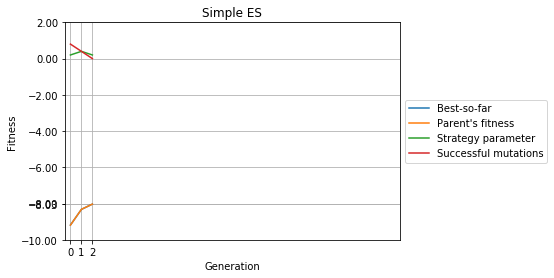

Best-so-far: gene = [ -2.9306 -1.9500 ], fit = -8.0298
--------------------------
Generation: 3
Parent:
gene = [ -2.9661 -1.4535 ], fit = -9.1723
Offspring:
gene = [ -2.7481 -1.5371 ], fit = -9.2945
gene = [ -2.9117 -1.2270 ], fit = -8.2816
gene = [ -3.0104 -1.8227 ], fit = -8.5060
gene = [ -3.0163 -1.2334 ], fit = -8.3709
gene = [ -3.1677 -1.5187 ], fit = -9.7695
gene = [ -3.0174 -1.3163 ], fit = -8.8201
gene = [ -3.2538 -1.1918 ], fit = -9.2847
gene = [ -2.9459 -1.3326 ], fit = -8.8076
gene = [ -3.0748 -1.3923 ], fit = -9.2521
gene = [ -2.7711 -1.1903 ], fit = -8.3798
Strategy parameter: 0.2


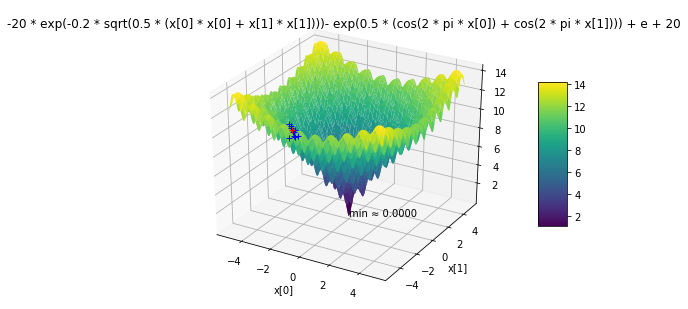

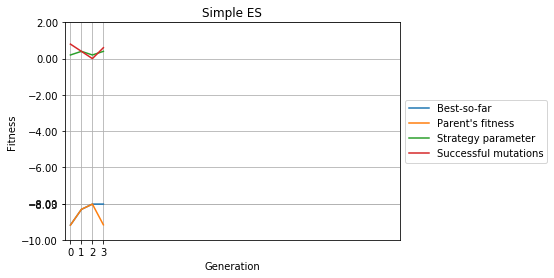

Best-so-far: gene = [ -2.9306 -1.9500 ], fit = -8.0298
--------------------------
Generation: 4
Parent:
gene = [ -2.9117 -1.2270 ], fit = -8.2816
Offspring:
gene = [ -2.9873 -1.0631 ], fit = -7.3348
gene = [ -3.0137 -1.2678 ], fit = -8.5660
gene = [ -2.9580 -1.5449 ], fit = -9.2400
gene = [ -3.3035 -1.0802 ], fit = -9.1705
gene = [ -3.0148 -1.9311 ], fit = -8.0740
gene = [ -2.8290 -0.9381 ], fit = -7.5817
gene = [ -2.1622 -1.3428 ], fit = -7.7773
gene = [ -3.1472 -1.8199 ], fit = -9.0866
gene = [ -2.7486 -1.1546 ], fit = -8.2788
gene = [ -1.6071 -1.0172 ], fit = -6.3233
Strategy parameter: 0.4


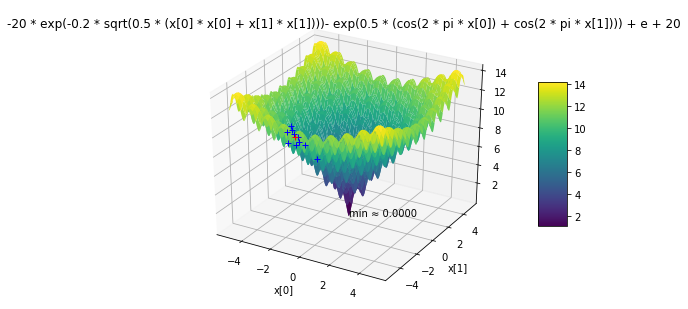

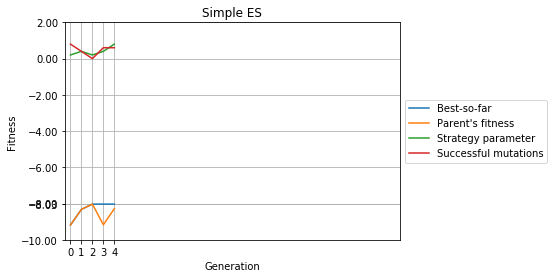

Best-so-far: gene = [ -1.6071 -1.0172 ], fit = -6.3233
--------------------------
Generation: 5
Parent:
gene = [ -1.6071 -1.0172 ], fit = -6.3233
Offspring:
gene = [ -1.3436 -0.3752 ], fit = -5.7674
gene = [ -2.0618 -1.2281 ], fit = -6.7727
gene = [ -1.6287 -0.4931 ], fit = -6.5664
gene = [ -1.1385 -0.8398 ], fit = -4.5412
gene = [ -2.4237 -1.0851 ], fit = -7.9931
gene = [ -1.0234 -1.6779 ], fit = -6.2539
gene = [ -0.2476 -1.1406 ], fit = -4.3776
gene = [ -3.1705 -1.3529 ], fit = -9.4945
gene = [ -1.2780 -0.3505 ], fit = -5.4540
gene = [ -0.5574 -1.3391 ], fit = -5.9470
Strategy parameter: 0.8


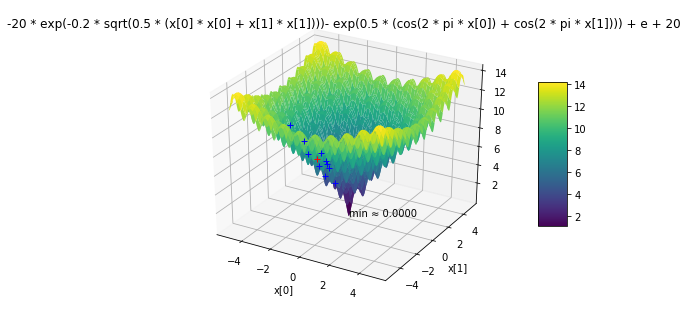

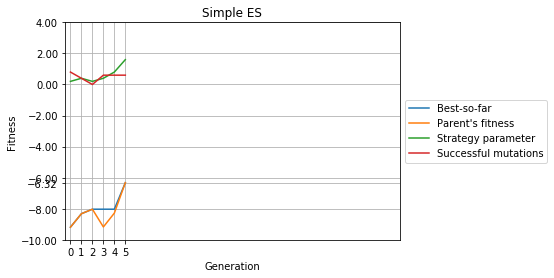

Best-so-far: gene = [ -0.2476 -1.1406 ], fit = -4.3776
--------------------------
Generation: 6
Parent:
gene = [ -0.2476 -1.1406 ], fit = -4.3776
Offspring:
gene = [ -0.1135 0.2982 ], fit = -2.3432
gene = [ 0.4529 -1.0306 ], fit = -4.6493
gene = [ -1.0806 -2.9066 ], fit = -7.4706
gene = [ -0.9350 -0.5007 ], fit = -4.5443
gene = [ 1.3803 -4.5155 ], fit = -12.0392
gene = [ 2.2042 -0.1081 ], fit = -6.3794
gene = [ -3.3779 -0.9923 ], fit = -9.4123
gene = [ 0.9472 0.1641 ], fit = -3.1862
gene = [ 0.8696 1.3718 ], fit = -5.8280
gene = [ -0.9728 1.4503 ], fit = -6.0780
Strategy parameter: 1.6


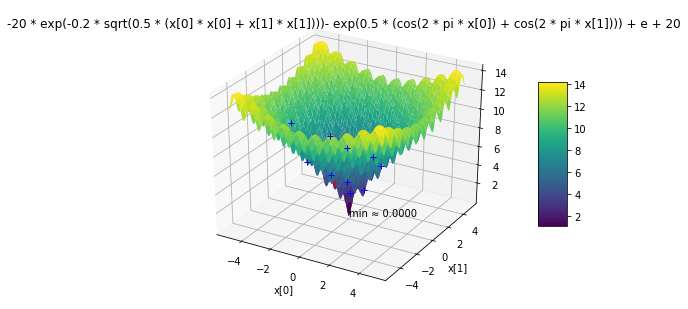

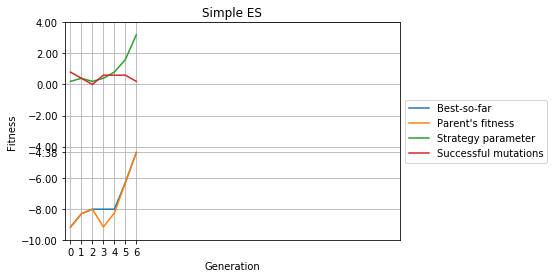

Best-so-far: gene = [ -0.1135 0.2982 ], fit = -2.3432
--------------------------
Generation: 7
Parent:
gene = [ -0.1135 0.2982 ], fit = -2.3432
Offspring:
gene = [ -3.3961 -0.4148 ], fit = -9.9528
gene = [ -5.0000 4.1967 ], fit = -12.8300
gene = [ -2.9079 -2.8101 ], fit = -9.6017
gene = [ -0.6318 1.7030 ], fit = -6.6325
gene = [ 2.5552 -0.6494 ], fit = -8.4778
gene = [ -5.0000 1.7325 ], fit = -11.6947
gene = [ -2.0075 0.6659 ], fit = -6.6082
gene = [ -2.6759 2.2758 ], fit = -9.8117
gene = [ 0.1303 5.0000 ], fit = -10.5391
gene = [ -1.3404 5.0000 ], fit = -11.8400
Strategy parameter: 3.2


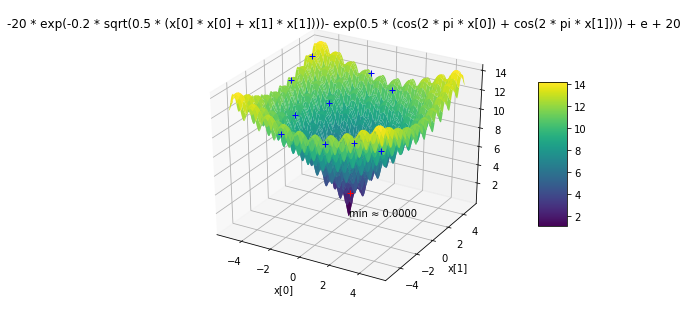

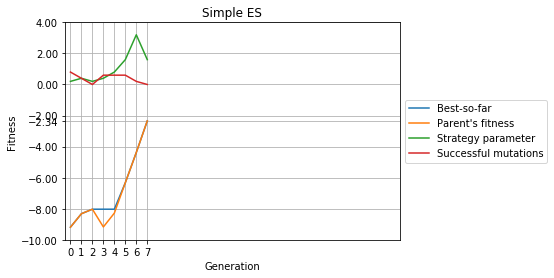

Best-so-far: gene = [ -0.1135 0.2982 ], fit = -2.3432
--------------------------
Generation: 8
Parent:
gene = [ -2.0075 0.6659 ], fit = -6.6082
Offspring:
gene = [ -1.4567 -0.4305 ], fit = -6.1917
gene = [ -0.5573 0.3193 ], fit = -3.9476
gene = [ -1.0038 0.1232 ], fit = -3.0268
gene = [ 0.6402 1.7986 ], fit = -6.6051
gene = [ -0.1331 1.6380 ], fit = -5.8542
gene = [ -4.0299 0.1308 ], fit = -9.1128
gene = [ -5.0000 0.3575 ], fit = -11.6685
gene = [ -2.9696 -1.8782 ], fit = -8.2070
gene = [ -4.2922 -0.1001 ], fit = -10.5059
gene = [ -0.8728 0.1889 ], fit = -3.3822
Strategy parameter: 1.6


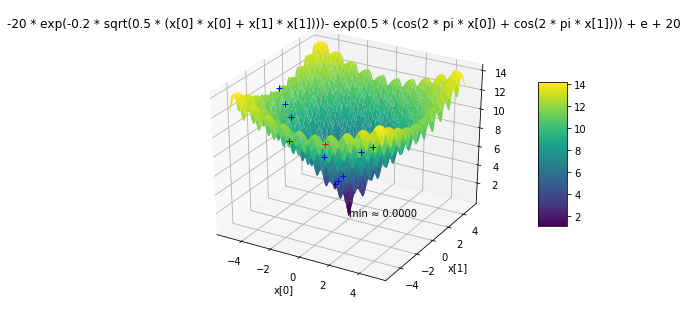

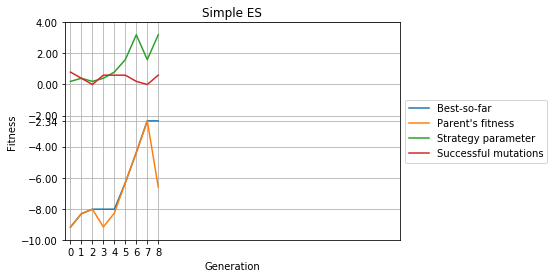

Best-so-far: gene = [ -0.1135 0.2982 ], fit = -2.3432
--------------------------
Generation: 9
Parent:
gene = [ -1.0038 0.1232 ], fit = -3.0268
Offspring:
gene = [ 5.0000 -5.0000 ], fit = -12.6424
gene = [ -4.0342 -1.6052 ], fit = -10.7966
gene = [ 0.8111 -3.1715 ], fit = -8.6013
gene = [ 0.0360 0.7610 ], fit = -3.0761
gene = [ -0.3895 -0.1641 ], fit = -2.9982
gene = [ -2.2713 -5.0000 ], fit = -11.9768
gene = [ -4.8202 -4.9779 ], fit = -13.1802
gene = [ -1.0681 1.3469 ], fit = -5.8503
gene = [ 1.0362 -0.2359 ], fit = -3.8076
gene = [ 0.2269 -2.0785 ], fit = -6.1682
Strategy parameter: 3.2


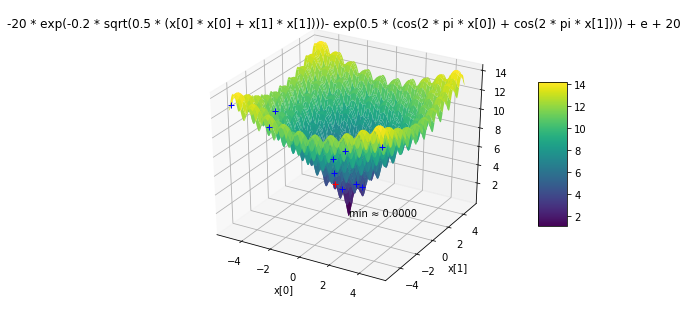

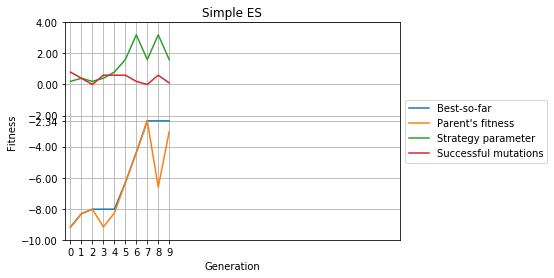

Best-so-far: gene = [ -0.1135 0.2982 ], fit = -2.3432
--------------------------
Generation: 10
Parent:
gene = [ -0.3895 -0.1641 ], fit = -2.9982
Offspring:
gene = [ 0.2280 1.0572 ], fit = -3.8440
gene = [ -1.3681 0.5473 ], fit = -6.0383
gene = [ 0.2875 1.4686 ], fit = -5.9879
gene = [ 3.0326 -0.6020 ], fit = -8.7093
gene = [ 0.4727 0.8099 ], fit = -4.4680
gene = [ 1.1528 -1.0116 ], fit = -4.4249
gene = [ -0.6020 0.3395 ], fit = -4.0675
gene = [ -1.8754 1.6783 ], fit = -7.5612
gene = [ 0.2179 -1.9785 ], fit = -5.8112
gene = [ -1.2679 0.3819 ], fit = -5.4799
Strategy parameter: 1.6


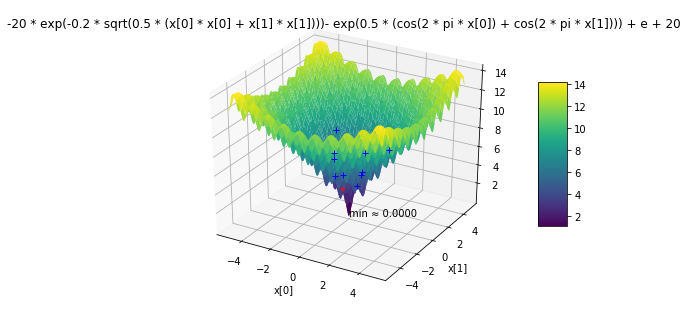

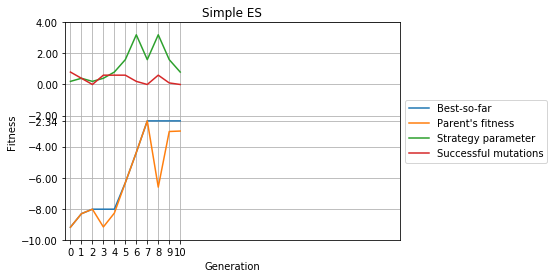

Best-so-far: gene = [ -0.1135 0.2982 ], fit = -2.3432
--------------------------
Generation: 11
Parent:
gene = [ 0.2280 1.0572 ], fit = -3.8440
Offspring:
gene = [ -0.6879 2.7665 ], fit = -8.4833
gene = [ -0.3932 1.0602 ], fit = -4.5981
gene = [ 0.7121 2.0010 ], fit = -6.4419
gene = [ 1.8692 0.3876 ], fit = -6.4894
gene = [ 0.7800 0.3156 ], fit = -4.0633
gene = [ 1.2397 1.3270 ], fit = -6.4299
gene = [ -0.4296 0.0572 ], fit = -2.8910
gene = [ 1.5731 0.2548 ], fit = -6.1247
gene = [ 1.2393 2.4813 ], fit = -8.5781
gene = [ -1.3352 -0.1578 ], fit = -5.1626
Strategy parameter: 0.8


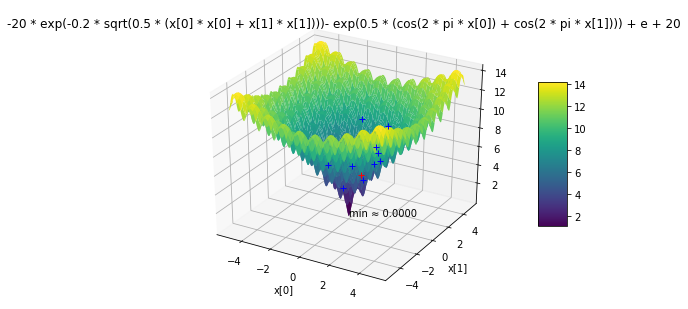

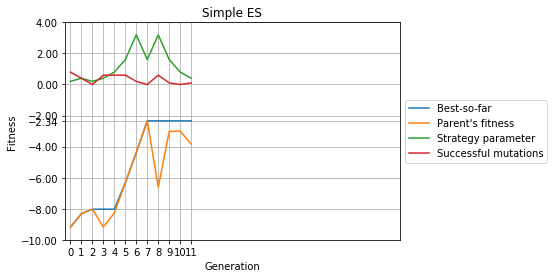

Best-so-far: gene = [ -0.1135 0.2982 ], fit = -2.3432
--------------------------
Generation: 12
Parent:
gene = [ -0.4296 0.0572 ], fit = -2.8910
Offspring:
gene = [ 0.0449 0.4498 ], fit = -2.9520
gene = [ -0.9180 -0.2230 ], fit = -3.5384
gene = [ -0.3886 -0.0759 ], fit = -2.7437
gene = [ -0.5680 -0.1011 ], fit = -3.3365
gene = [ -0.3442 0.0997 ], fit = -2.5723
gene = [ -0.2589 0.3686 ], fit = -3.2599
gene = [ -0.4153 0.4636 ], fit = -4.0040
gene = [ 0.1329 0.2292 ], fit = -1.9606
gene = [ -0.1762 1.0232 ], fit = -3.3985
gene = [ -0.5840 -0.1430 ], fit = -3.4622
Strategy parameter: 0.4


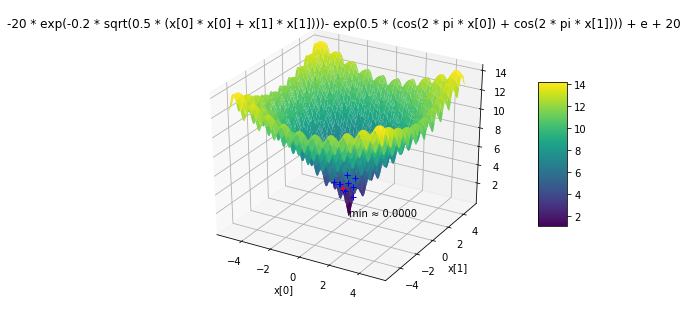

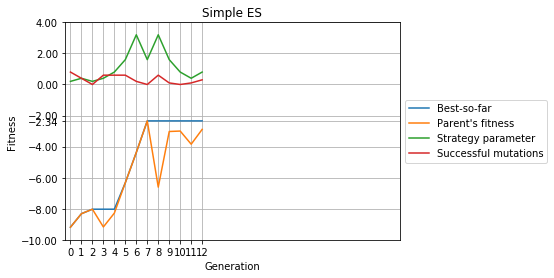

Best-so-far: gene = [ 0.1329 0.2292 ], fit = -1.9606
--------------------------
Generation: 13
Parent:
gene = [ 0.1329 0.2292 ], fit = -1.9606
Offspring:
gene = [ 0.6878 0.5360 ], fit = -4.5308
gene = [ -0.7386 -0.2586 ], fit = -3.8745
gene = [ 2.2608 -0.1847 ], fit = -7.0267
gene = [ -0.5867 0.4400 ], fit = -4.2789
gene = [ 0.3074 -0.9544 ], fit = -4.0082
gene = [ -0.1294 1.5975 ], fit = -5.8377
gene = [ 0.7825 -0.7584 ], fit = -4.4386
gene = [ 0.9396 0.2117 ], fit = -3.4724
gene = [ -0.4871 0.5676 ], fit = -4.3406
gene = [ 0.4140 0.6428 ], fit = -4.2912
Strategy parameter: 0.8


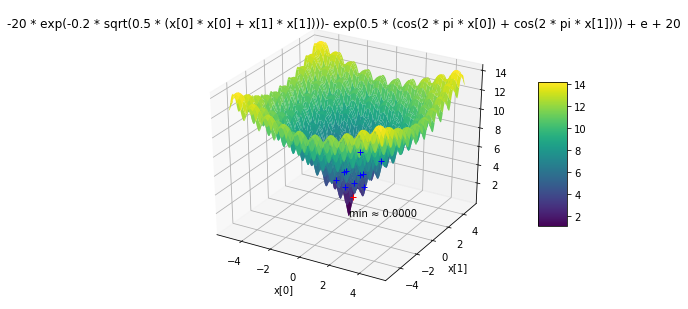

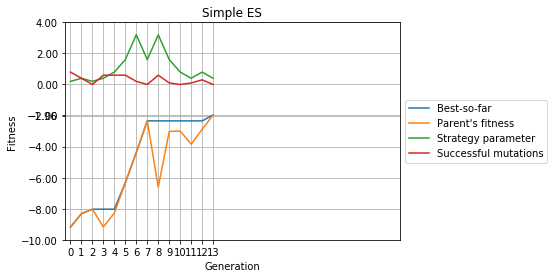

Best-so-far: gene = [ 0.1329 0.2292 ], fit = -1.9606
--------------------------
Generation: 14
Parent:
gene = [ 0.9396 0.2117 ], fit = -3.4724
Offspring:
gene = [ 1.2599 0.1557 ], fit = -4.7230
gene = [ 1.0547 -0.3960 ], fit = -4.5873
gene = [ 0.5466 -0.0160 ], fit = -3.1877
gene = [ 0.6158 0.5704 ], fit = -4.5188
gene = [ 0.3662 0.1849 ], fit = -2.9716
gene = [ 0.4692 0.4014 ], fit = -3.9832
gene = [ -0.0651 -0.2612 ], fit = -1.9378
gene = [ 1.2218 -0.2280 ], fit = -4.7719
gene = [ 1.0399 0.8737 ], fit = -3.9085
gene = [ 0.7803 -0.5957 ], fit = -4.5830
Strategy parameter: 0.4


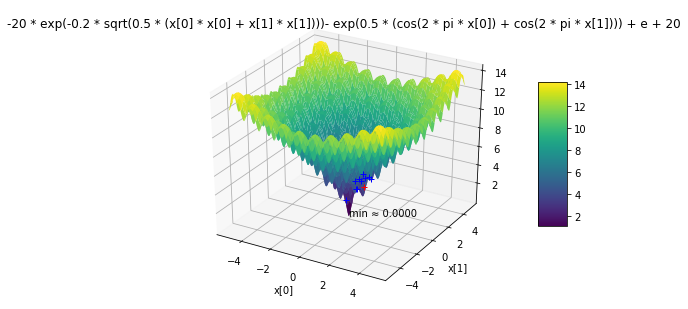

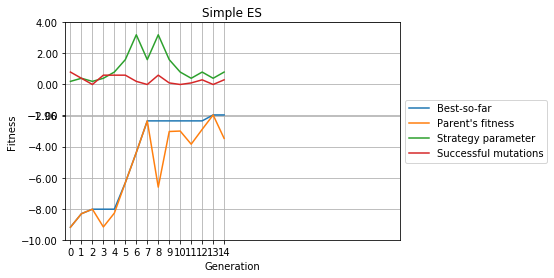

Best-so-far: gene = [ -0.0651 -0.2612 ], fit = -1.9378
--------------------------
Generation: 15
Parent:
gene = [ -0.0651 -0.2612 ], fit = -1.9378
Offspring:
gene = [ 0.9959 -1.9042 ], fit = -5.4704
gene = [ 0.6307 -0.9919 ], fit = -4.6093
gene = [ 0.2628 -1.2514 ], fit = -5.0705
gene = [ -1.2585 -2.4769 ], fit = -8.6228
gene = [ -1.0125 -0.6367 ], fit = -4.6431
gene = [ -0.4533 0.1322 ], fit = -3.1419
gene = [ 0.6622 0.7495 ], fit = -4.5879
gene = [ 1.0711 0.0359 ], fit = -2.9756
gene = [ 0.7181 -0.0965 ], fit = -3.3010
gene = [ 0.3215 0.9279 ], fit = -4.0499
Strategy parameter: 0.8


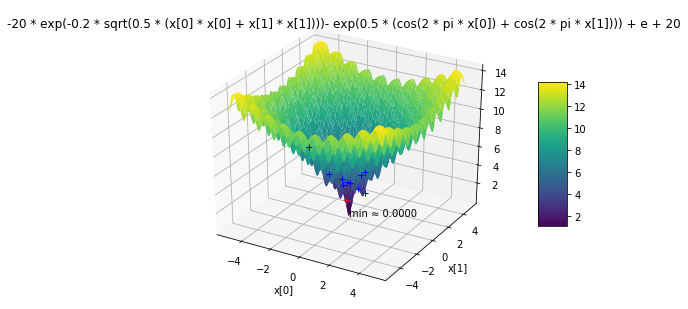

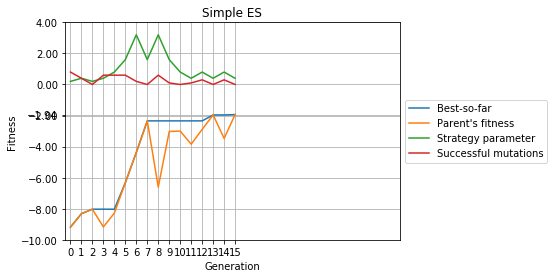

Best-so-far: gene = [ -0.0651 -0.2612 ], fit = -1.9378
--------------------------
Generation: 16
Parent:
gene = [ 1.0711 0.0359 ], fit = -2.9756
Offspring:
gene = [ 1.2020 0.0908 ], fit = -4.0856
gene = [ 1.4965 -0.2220 ], fit = -5.9084
gene = [ 1.5670 0.2244 ], fit = -6.0434
gene = [ 0.7895 -0.4293 ], fit = -4.3854
gene = [ 1.2632 -0.0845 ], fit = -4.5201
gene = [ 1.0027 -0.7332 ], fit = -4.3764
gene = [ 1.9433 0.2214 ], fit = -5.8040
gene = [ 0.2111 -0.2227 ], fit = -2.3381
gene = [ 0.9111 -0.1452 ], fit = -3.0895
gene = [ 0.9004 0.3457 ], fit = -4.1383
Strategy parameter: 0.4


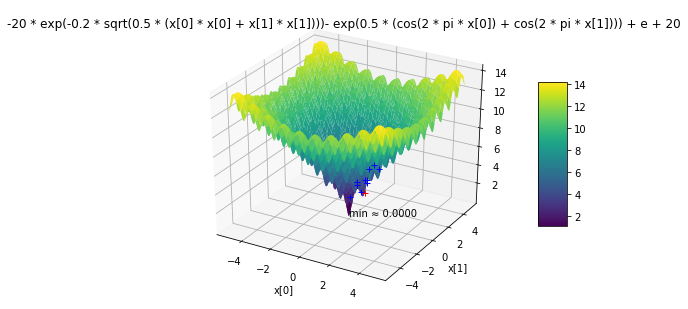

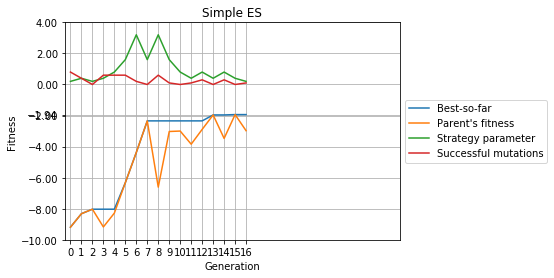

Best-so-far: gene = [ -0.0651 -0.2612 ], fit = -1.9378
--------------------------
Generation: 17
Parent:
gene = [ 0.2111 -0.2227 ], fit = -2.3381
Offspring:
gene = [ -0.1739 0.1663 ], fit = -1.7698
gene = [ 0.2593 -0.1511 ], fit = -2.2500
gene = [ 0.0426 -0.1819 ], fit = -1.2467
gene = [ 0.6591 0.0837 ], fit = -3.3358
gene = [ 0.2890 -0.2930 ], fit = -3.0741
gene = [ 0.0939 -0.4666 ], fit = -3.0910
gene = [ 0.2198 -0.2168 ], fit = -2.3535
gene = [ 0.4063 0.0143 ], fit = -2.7501
gene = [ -0.0223 -0.2511 ], fit = -1.7839
gene = [ 0.2677 -0.2587 ], fit = -2.8234
Strategy parameter: 0.2


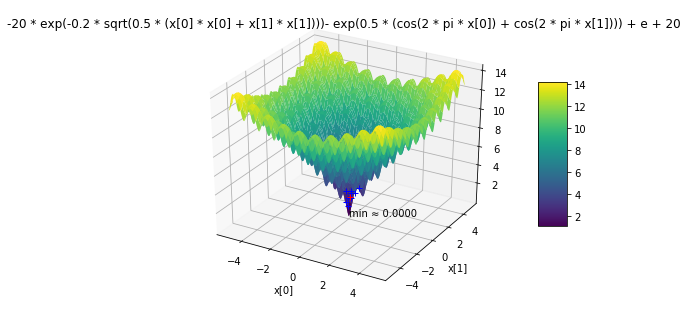

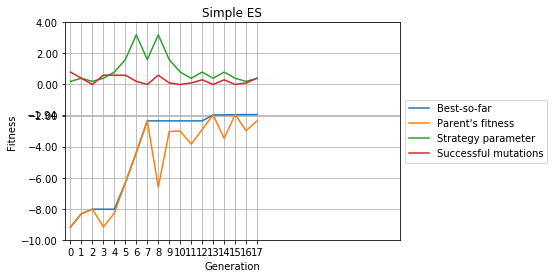

Best-so-far: gene = [ 0.0426 -0.1819 ], fit = -1.2467
--------------------------
Generation: 18
Parent:
gene = [ 0.0426 -0.1819 ], fit = -1.2467
Offspring:
gene = [ 0.0165 0.2928 ], fit = -2.0911
gene = [ 0.5845 -0.5878 ], fit = -4.5062
gene = [ -0.9268 0.2334 ], fit = -3.5978
gene = [ -0.2386 -0.4974 ], fit = -3.5905
gene = [ 1.0580 0.3197 ], fit = -4.3215
gene = [ -0.0501 0.2566 ], fit = -1.8686
gene = [ -0.4578 0.0665 ], fit = -3.0100
gene = [ -0.0310 -0.2375 ], fit = -1.6860
gene = [ 0.6899 -1.4256 ], fit = -6.1994
gene = [ 1.0456 -0.3880 ], fit = -4.5334
Strategy parameter: 0.4


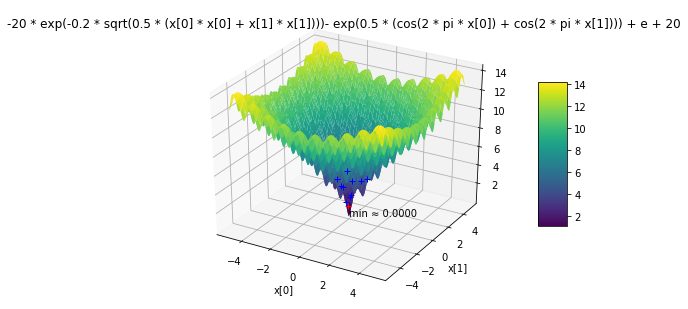

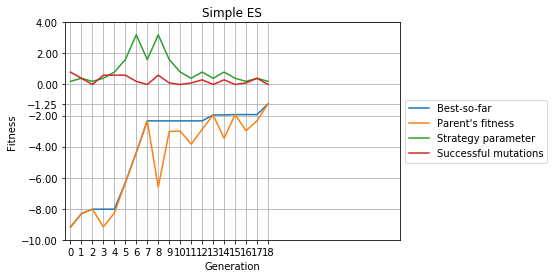

Best-so-far: gene = [ 0.0426 -0.1819 ], fit = -1.2467
--------------------------
Generation: 19
Parent:
gene = [ -0.0310 -0.2375 ], fit = -1.6860
Offspring:
gene = [ -0.0839 0.0355 ], fit = -0.4657
gene = [ -0.1928 -0.3252 ], fit = -2.8100
gene = [ -0.0489 -0.2533 ], fit = -1.8409
gene = [ 0.0535 -0.0134 ], fit = -0.2350
gene = [ -0.4766 -0.3306 ], fit = -3.8148
gene = [ 0.0748 -0.3691 ], fit = -2.6441
gene = [ 0.1467 0.1448 ], fit = -1.4540
gene = [ -0.0312 -0.2751 ], fit = -1.9768
gene = [ -0.4312 -0.3598 ], fit = -3.7833
gene = [ 0.1814 -0.3810 ], fit = -3.0230
Strategy parameter: 0.2


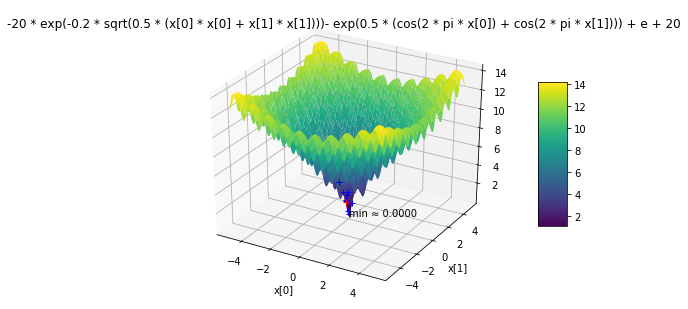

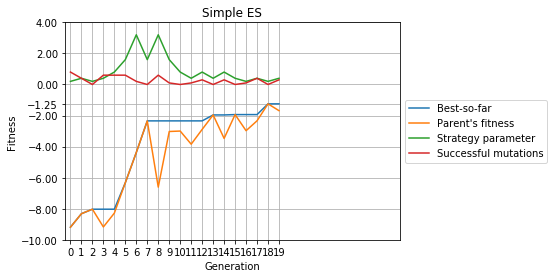

Best-so-far: gene = [ 0.0535 -0.0134 ], fit = -0.2350
--------------------------
Generation: 20
Parent:
gene = [ 0.0535 -0.0134 ], fit = -0.2350
Offspring:
gene = [ 0.7727 0.9075 ], fit = -4.1899
gene = [ -0.0424 0.2331 ], fit = -1.6694
gene = [ -0.2366 -0.5479 ], fit = -3.6899
gene = [ 0.0131 0.2464 ], fit = -1.7394
gene = [ 0.3772 0.4037 ], fit = -3.7583
gene = [ 0.5574 0.0690 ], fit = -3.2593
gene = [ 0.0821 -0.0258 ], fit = -0.4299
gene = [ 0.1119 0.0884 ], fit = -0.8778
gene = [ 0.5916 0.0752 ], fit = -3.3097
gene = [ -0.4319 -0.0400 ], fit = -2.8783
Strategy parameter: 0.4


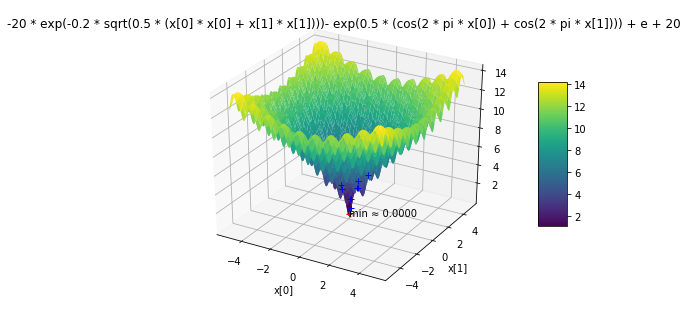

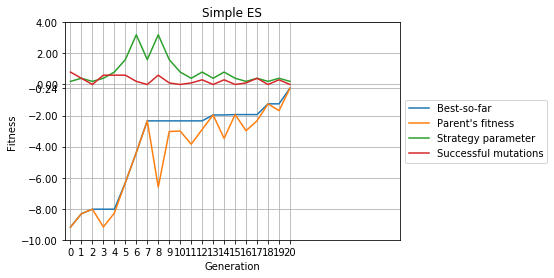

Best-so-far: gene = [ 0.0535 -0.0134 ], fit = -0.2350
--------------------------
Generation: 21
Parent:
gene = [ 0.0821 -0.0258 ], fit = -0.4299
Offspring:
gene = [ 0.2092 0.1439 ], fit = -1.8770
gene = [ 0.1536 -0.2847 ], fit = -2.4193
gene = [ 0.0518 -0.3779 ], fit = -2.6482
gene = [ 0.2327 -0.0048 ], fit = -1.6258
gene = [ -0.0643 -0.0834 ], fit = -0.5725
gene = [ 0.2456 -0.4595 ], fit = -3.5138
gene = [ 0.0580 0.0820 ], fit = -0.5353
gene = [ 0.3267 0.0866 ], fit = -2.4352
gene = [ 0.3627 0.0593 ], fit = -2.5801
gene = [ -0.0473 -0.1214 ], fit = -0.7681
Strategy parameter: 0.2


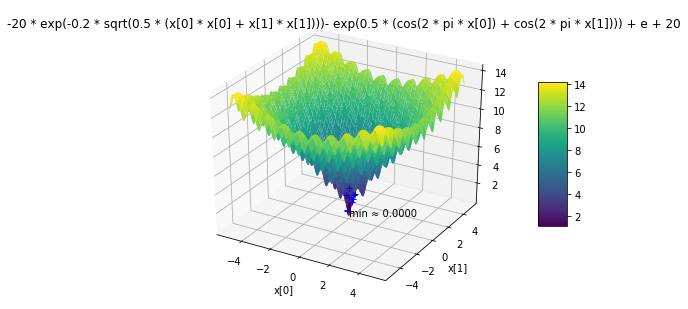

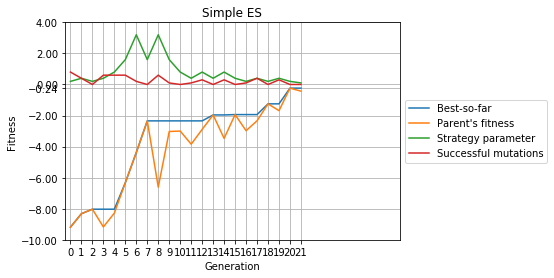

Best-so-far: gene = [ 0.0535 -0.0134 ], fit = -0.2350
--------------------------
Generation: 22
Parent:
gene = [ 0.0580 0.0820 ], fit = -0.5353
Offspring:
gene = [ 0.0935 0.0440 ], fit = -0.5554
gene = [ -0.0050 0.0913 ], fit = -0.4665
gene = [ 0.1197 -0.0465 ], fit = -0.7525
gene = [ 0.0115 -0.0252 ], fit = -0.0988
gene = [ 0.2189 -0.0242 ], fit = -1.5250
gene = [ 0.1092 -0.0875 ], fit = -0.8551
gene = [ -0.1242 -0.0154 ], fit = -0.7228
gene = [ 0.0911 -0.0871 ], fit = -0.7384
gene = [ -0.0116 0.0610 ], fit = -0.2749
gene = [ 0.0872 0.1388 ], fit = -1.0629
Strategy parameter: 0.1


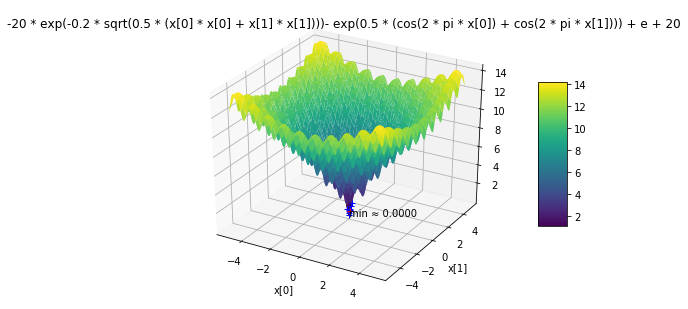

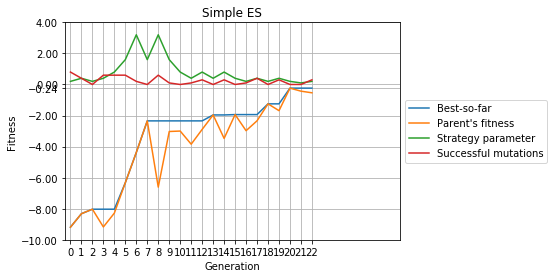

Best-so-far: gene = [ 0.0115 -0.0252 ], fit = -0.0988
--------------------------
Generation: 23
Parent:
gene = [ 0.0115 -0.0252 ], fit = -0.0988
Offspring:
gene = [ 0.0952 -0.4381 ], fit = -2.9954
gene = [ 0.1025 0.0207 ], fit = -0.5633
gene = [ -0.0350 -0.2579 ], fit = -1.8524
gene = [ -0.3794 -0.1597 ], fit = -2.9395
gene = [ 0.3026 -0.1165 ], fit = -2.3814
gene = [ -0.0705 0.2360 ], fit = -1.7617
gene = [ -0.3512 -0.1070 ], fit = -2.6313
gene = [ 0.0526 -0.3349 ], fit = -2.4099
gene = [ 0.4903 -0.2237 ], fit = -3.5270
gene = [ 0.0787 -0.4504 ], fit = -3.0056
Strategy parameter: 0.2


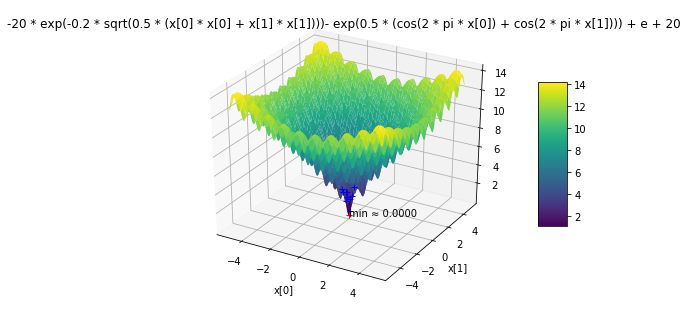

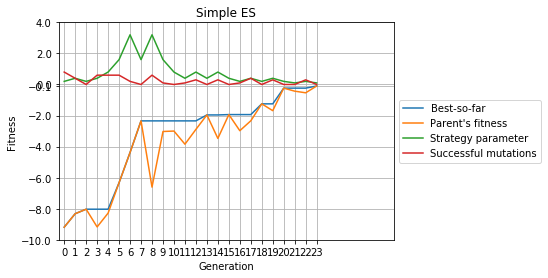

Best-so-far: gene = [ 0.0115 -0.0252 ], fit = -0.0988
--------------------------
Generation: 24
Parent:
gene = [ 0.1025 0.0207 ], fit = -0.5633
Offspring:
gene = [ -0.0061 -0.0129 ], fit = -0.0458
gene = [ -0.0205 -0.1497 ], fit = -0.9368
gene = [ 0.1462 0.0964 ], fit = -1.1642
gene = [ 0.0762 0.0276 ], fit = -0.3954
gene = [ -0.0076 0.0960 ], fit = -0.5017
gene = [ 0.1385 -0.1969 ], fit = -1.7621
gene = [ 0.1546 0.0258 ], fit = -0.9851
gene = [ 0.2822 0.0069 ], fit = -2.0105
gene = [ 0.2387 -0.0166 ], fit = -1.6798
gene = [ 0.3353 0.1052 ], fit = -2.5384
Strategy parameter: 0.1


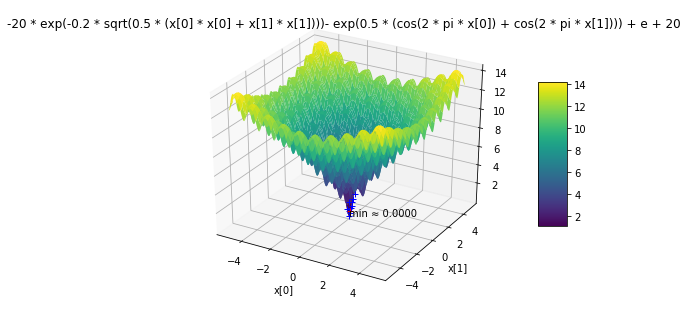

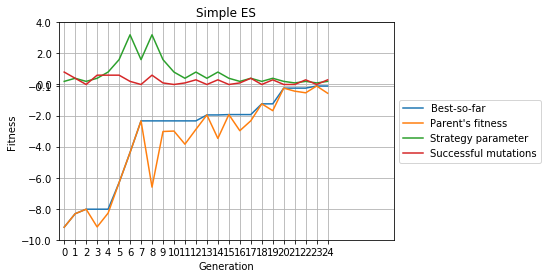

Best-so-far: gene = [ -0.0061 -0.0129 ], fit = -0.0458
--------------------------
Generation: 25
Parent:
gene = [ -0.0061 -0.0129 ], fit = -0.0458
Offspring:
gene = [ 0.2451 -0.1212 ], fit = -2.0185
gene = [ -0.0250 0.4474 ], fit = -2.9252
gene = [ -0.1383 0.3188 ], fit = -2.5576
gene = [ -0.0882 0.1341 ], fit = -1.0334
gene = [ 0.0198 0.2037 ], fit = -1.3928
gene = [ -0.1714 -0.0070 ], fit = -1.1093
gene = [ -0.0963 -0.1462 ], fit = -1.1637
gene = [ -0.0882 -0.2141 ], fit = -1.6521
gene = [ 0.1803 -0.1284 ], fit = -1.5878
gene = [ -0.1040 0.3503 ], fit = -2.6176
Strategy parameter: 0.2


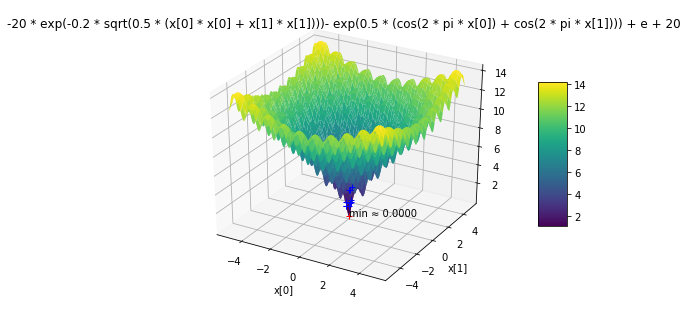

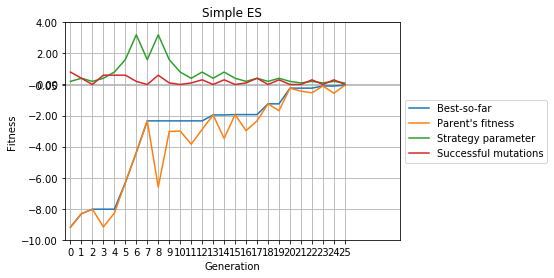

Best-so-far: gene = [ -0.0061 -0.0129 ], fit = -0.0458
--------------------------
Generation: 26
Parent:
gene = [ -0.0882 0.1341 ], fit = -1.0334
Offspring:
gene = [ -0.1358 0.0783 ], fit = -0.9980
gene = [ -0.1412 0.0278 ], fit = -0.8775
gene = [ -0.0186 0.1863 ], fit = -1.2444
gene = [ -0.2013 0.1848 ], fit = -2.0575
gene = [ -0.2062 -0.0402 ], fit = -1.4446
gene = [ -0.1133 0.0420 ], fit = -0.6910
gene = [ -0.1973 0.1919 ], fit = -2.0754
gene = [ -0.0780 0.1342 ], fit = -0.9843
gene = [ -0.1310 0.2592 ], fit = -2.1585
gene = [ -0.1657 0.0932 ], fit = -1.2962
Strategy parameter: 0.1


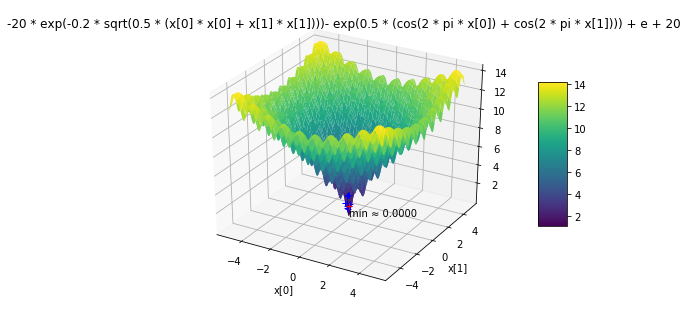

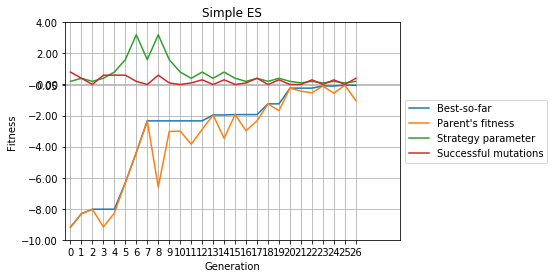

Best-so-far: gene = [ -0.0061 -0.0129 ], fit = -0.0458
--------------------------
Generation: 27
Parent:
gene = [ -0.1133 0.0420 ], fit = -0.6910
Offspring:
gene = [ -0.1020 0.1581 ], fit = -1.2822
gene = [ -0.0569 0.1412 ], fit = -0.9539
gene = [ -0.1881 0.0155 ], fit = -1.2565
gene = [ -0.1064 -0.0156 ], fit = -0.5853
gene = [ -0.4054 0.4921 ], fit = -4.0418
gene = [ -0.0278 0.1724 ], fit = -1.1382
gene = [ -0.1194 0.1989 ], fit = -1.6763
gene = [ -0.1313 -0.2263 ], fit = -1.9326
gene = [ 0.1167 -0.2029 ], fit = -1.6923
gene = [ -0.2421 0.1869 ], fit = -2.3212
Strategy parameter: 0.2


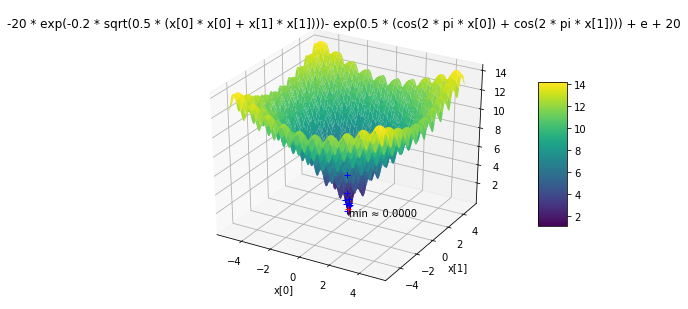

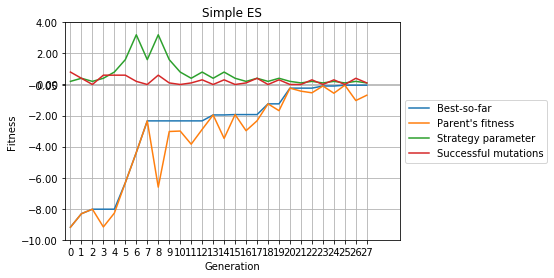

Best-so-far: gene = [ -0.0061 -0.0129 ], fit = -0.0458
--------------------------
Generation: 28
Parent:
gene = [ -0.1064 -0.0156 ], fit = -0.5853
Offspring:
gene = [ -0.1359 -0.0184 ], fit = -0.8202
gene = [ -0.1773 -0.0715 ], fit = -1.2960
gene = [ 0.1336 -0.1612 ], fit = -1.4824
gene = [ -0.0579 -0.0039 ], fit = -0.2515
gene = [ -0.0382 -0.0359 ], fit = -0.2201
gene = [ -0.0741 0.1321 ], fit = -0.9515
gene = [ -0.1821 -0.0260 ], fit = -1.2173
gene = [ -0.2149 -0.0888 ], fit = -1.6604
gene = [ -0.1361 0.0535 ], fit = -0.9017
gene = [ -0.1205 -0.1109 ], fit = -1.0659
Strategy parameter: 0.1


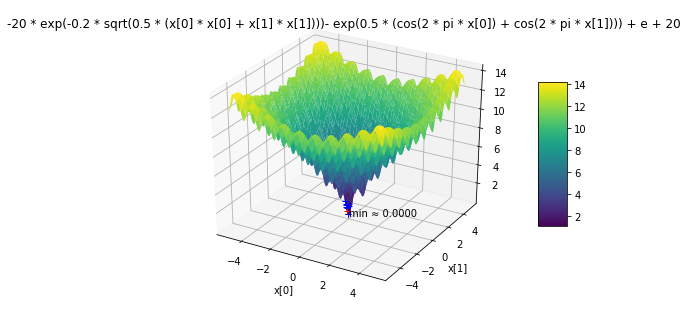

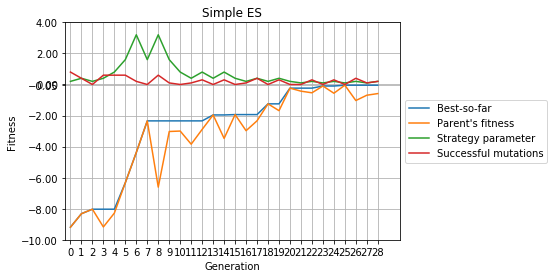

Best-so-far: gene = [ -0.0061 -0.0129 ], fit = -0.0458
--------------------------
Generation: 29
Parent:
gene = [ -0.0382 -0.0359 ], fit = -0.2201
Offspring:
gene = [ -0.1958 0.3033 ], fit = -2.7109
gene = [ -0.2869 0.0828 ], fit = -2.1692
gene = [ -0.1387 0.1476 ], fit = -1.4207
gene = [ -0.2867 -0.0713 ], fit = -2.1365
gene = [ -0.2156 -0.0146 ], fit = -1.4885
gene = [ 0.2106 -0.0666 ], fit = -1.5486
gene = [ 0.1519 -0.0704 ], fit = -1.0888
gene = [ 0.0566 0.2881 ], fit = -2.1127
gene = [ 0.2088 0.1125 ], fit = -1.7156
gene = [ -0.2561 -0.0807 ], fit = -1.9449
Strategy parameter: 0.2


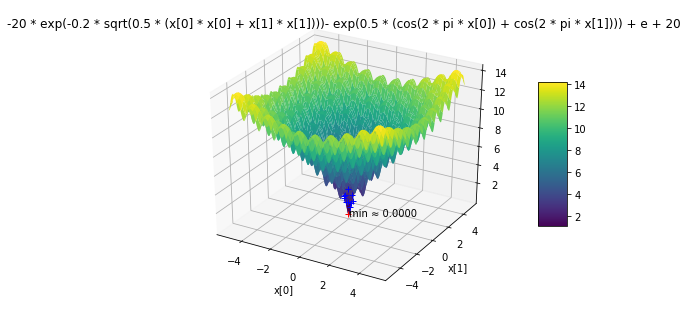

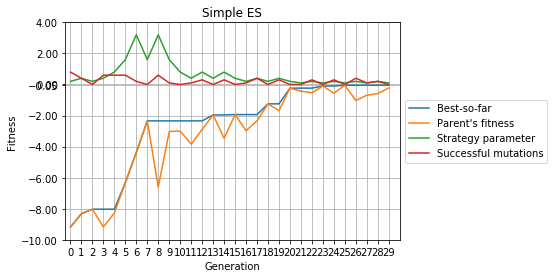

Best-so-far: gene = [ -0.0061 -0.0129 ], fit = -0.0458

The best individual founded: gene = [ -0.0061 -0.0129 ], fit = -0.0458
Solution:
x = [ 0.15193571 -0.07043007]
y = f(x) = 1.0887948048228253


In [16]:
es = ES(fn, params)
best_indiv = es.run()

# Display result
print("\nThe best individual founded:", best_indiv)

print("Solution:")
x = es.parent.genes
print("x =", x)
y = es.evaluator.function.evaluate(x)
print("y = f(x) =", y)